<a id='top'></a>
<div class="list-group" id="list-tab" role="tablist">
    
<h1 style="padding: 8px;color:white; display:fill;background-color:#555555; border-radius:5px; font-size:150%"><b> Table of contents </b></h1>

 - [Introduction](#1)

 - [Explore](#2)

 - [Pre-processing and feature selection](#3)
    
 - [Modelling and Evaluation](#4)
    - [Logistical Classification](#4_1)
    - [Decision Tree](#4_3)
    - [Random Forest](#4_5)
    - [Gradient Boosting Classifier](#4_6)
    - [Neural Network MLP](#4_7)
    
 - [Evaluate](#5)
 - [Conclusion](#6)
   

<a id='1'></a>
# <p style="padding: 8px;color:white; display:fill;background-color:#555555; border-radius:5px; font-size:100%"> <b>Introduction</b>

This synthetic dataset is modeled after an existing milling machine and consists of 10 000 data points from a stored as rows with 14 features in columns

1. UID: unique identifier ranging from 1 to 10000
2. product ID: consisting of a letter L, M, or H for low (50% of all products), medium (30%) and high (20%) as product quality variants and a variant-specific serial number
3. type: just the product type L, M or H from column 2
4. air temperature [K]: generated using a random walk process later normalized to a standard deviation of 2 K around 300 K
5. process temperature [K]: generated using a random walk process normalized to a standard deviation of 1 K, added to the air temperature plus 10 K.
6. rotational speed [rpm]: calculated from a power of 2860 W, overlaid with a normally distributed noise
7. torque [Nm]: torque values are normally distributed around 40 Nm with a SD = 10 Nm and no negative values.
8. tool wear [min]: The quality variants H/M/L add 5/3/2 minutes of tool wear to the used tool in the process.
9. a 'machine failure' label that indicates, whether the machine has failed in this particular datapoint for any of the following failure modes are true.

The machine failure consists of five independent failure modes

1. tool wear failure (TWF): the tool will be replaced of fail at a randomly selected tool wear time between 200 - 240 mins (120 times in our dataset). At this point in time, the tool is replaced 69 times, and fails 51 times (randomly assigned).
2. heat dissipation failure (HDF): heat dissipation causes a process failure, if the difference between air- and process temperature is below 8.6 K and the tools rotational speed is below 1380 rpm. This is the case for 115 data points.
3. power failure (PWF): the product of torque and rotational speed (in rad/s) equals the power required for the process. If this power is below 3500 W or above 9000 W, the process fails, which is the case 95 times in our dataset.
4. overstrain failure (OSF): if the product of tool wear and torque exceeds 11,000 minNm for the L product variant (12,000 M, 13,000 H), the process fails due to overstrain. This is true for 98 datapoints.
5. random failures (RNF): each process has a chance of 0,1 % to fail regardless of its process parameters. This is the case for only 5 datapoints, less than could be expected for 10,000 datapoints in our dataset.

If at least one of the above failure modes is true, the process fails and the 'machine failure' label is set to 1. It is therefore not transparent to the machine learning method, which of the failure modes has caused the process to fail.


<a id='2'></a>
# <p style="padding: 8px;color:white; display:fill;background-color:#555555; border-radius:5px; font-size:100%"> <b>Explore</b>

1. Imports essential libraries like `numpy`, `pandas`, `matplotlib`, `seaborn`, and `plotly` for data analysis and visualization.  
2. Configures Pandas to display all columns, up to 500 rows, and prevents DataFrame wrapping.  
3. Modifies Jupyter Notebook output to have a scrollable height of `35em` for better readability.  
4. Reloads `matplotlib` settings and ensures plots appear inline with high resolution (`retina`).  
5. Suppresses warnings to keep the notebook output clean.  
6. Sets Plotly's default renderer to `iframe`, ensuring compatibility with Jupyter.  
7. Creates a custom Plotly template (`ck_template`) with the Viridis color scheme, fixed size (800×600), and Calibri font.  
8. Applies `ck_template+gridon` as the default Plotly theme, adding grid lines for better readability.  
9. Provides an alternative template (`seaborn+gridon`), which is commented out.  
10. Optimizes the notebook environment for efficient data analysis and visualization. 🚀

In [1]:
import numpy as np
import pandas as pd

from IPython.core.display import display, HTML
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.io as pio


import seaborn as sns
from importlib import reload
import matplotlib.pyplot as plt
import matplotlib
import warnings

# Configure Jupyter Notebook
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 500)
pd.set_option('display.expand_frame_repr', False)
# pd.set_option('max_colwidth', -1)
display(HTML("<style>div.output_scroll { height: 35em; }</style>"))

reload(plt)
%matplotlib inline
%config InlineBackend.figure_format ='retina'

warnings.filterwarnings('ignore')

# configure plotly graph objects
pio.renderers.default = 'iframe'
# pio.renderers.default = 'vscode'

pio.templates["ck_template"] = go.layout.Template(
    layout_colorway = px.colors.sequential.Viridis,
#     layout_hovermode = 'closest',
#     layout_hoverdistance = -1,
    layout_autosize=False,
    layout_width=800,
    layout_height=600,
    layout_font = dict(family="Calibri Light"),
    layout_title_font = dict(family="Calibri"),
    layout_hoverlabel_font = dict(family="Calibri Light"),
#     plot_bgcolor="white",
)

# pio.templates.default = 'seaborn+ck_template+gridon'
pio.templates.default = 'ck_template+gridon'
# pio.templates.default = 'seaborn+gridon'
# pio.templates

In [2]:
df = pd.read_csv('ai4i2020.csv')
# df = pd.read_csv('ai4i2020.csv')

First up is just to eyeball the data. It seems that there are two indices: the index and ProductID. We can drop those. There is a Type which is categorical and the remainder are numeric. The last five feastures are all failure modes, so they will not be evaluated in this notebook.

In [3]:
df.head()

UDI Product ID Type  Air temperature [K]  Process temperature [K]  Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Machine failure  TWF  HDF  PWF  OSF  RNF
0    1     M14860    M                298.1                    308.6                    1551         42.8                0                0    0    0    0    0    0
1    2     L47181    L                298.2                    308.7                    1408         46.3                3                0    0    0    0    0    0
2    3     L47182    L                298.1                    308.5                    1498         49.4                5                0    0    0    0    0    0
3    4     L47183    L                298.2                    308.6                    1433         39.5                7                0    0    0    0    0    0
4    5     L47184    L                298.2                    308.7                    1408         40.0                9                0    0    0    0    0    0

There are no apparent missing values, but we'll check these out carefully to make sure

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Machine failure          10000 non-null  int64  
 9   TWF                      10000 non-null  int64  
 10  HDF                      10000 non-null  int64  
 11  PWF                      10000 non-null  int64  
 12  OSF                      10000 non-null  int64  
 13  RNF                      10000 non-null  int64  
dtypes: float64(3), int64(9)

In [5]:
df.describe(include='all').T

count unique     top  freq       mean         std     min      25%     50%      75%      max
UDI                      10000.0    NaN     NaN   NaN     5000.5  2886.89568     1.0  2500.75  5000.5  7500.25  10000.0
Product ID                 10000  10000  M14860     1        NaN         NaN     NaN      NaN     NaN      NaN      NaN
Type                       10000      3       L  6000        NaN         NaN     NaN      NaN     NaN      NaN      NaN
Air temperature [K]      10000.0    NaN     NaN   NaN  300.00493    2.000259   295.3    298.3   300.1    301.5    304.5
Process temperature [K]  10000.0    NaN     NaN   NaN  310.00556    1.483734   305.7    308.8   310.1    311.1    313.8
Rotational speed [rpm]   10000.0    NaN     NaN   NaN  1538.7761  179.284096  1168.0   1423.0  1503.0   1612.0   2886.0
Torque [Nm]              10000.0    NaN     NaN   NaN   39.98691    9.968934     3.8     33.2    40.1     46.8     76.6
Tool wear [min]          10000.0    NaN     NaN   NaN    107.951   63.654147     0.0     53.0   108.0    162.0    253.0
Machine failure          10000.0    NaN     NaN   NaN     0.0339    0.180981     0.0      0.0     0.0      0.0      1.0
TWF                      10000.0    NaN     NaN   NaN     0.0046    0.067671     0.0      0.0     0.0      0.0      1.0
HDF                      10000.0    NaN     NaN   NaN     0.0115    0.106625     0.0      0.0     0.0      0.0      1.0
PWF                      10000.0    NaN     NaN   NaN     0.0095    0.097009     0.0      0.0     0.0      0.0      1.0
OSF                      10000.0    NaN     NaN   NaN     0.0098    0.098514     0.0      0.0     0.0      0.0      1.0
RNF                      10000.0    NaN     NaN   NaN     0.0019     0.04355     0.0      0.0     0.0      0.0      1.0

making sure that there are no missing values hidden as a question mark

In [6]:
df.replace("?",np.nan,inplace=True)

turn all columns into float to make processing later easier

In [7]:
for column in df.columns:
    try:
        df[column]=df[column].astype(float)
    except:
        pass

just check the descriptions for the numeric features. None missing and on apparent outliers

In [8]:
# show the numeric characters
df_numeric = df.select_dtypes(include=[np.number])
df_numeric.describe(include='all').T

count        mean          std     min      25%     50%      75%      max
UDI                      10000.0  5000.50000  2886.895680     1.0  2500.75  5000.5  7500.25  10000.0
Air temperature [K]      10000.0   300.00493     2.000259   295.3   298.30   300.1   301.50    304.5
Process temperature [K]  10000.0   310.00556     1.483734   305.7   308.80   310.1   311.10    313.8
Rotational speed [rpm]   10000.0  1538.77610   179.284096  1168.0  1423.00  1503.0  1612.00   2886.0
Torque [Nm]              10000.0    39.98691     9.968934     3.8    33.20    40.1    46.80     76.6
Tool wear [min]          10000.0   107.95100    63.654147     0.0    53.00   108.0   162.00    253.0
Machine failure          10000.0     0.03390     0.180981     0.0     0.00     0.0     0.00      1.0
TWF                      10000.0     0.00460     0.067671     0.0     0.00     0.0     0.00      1.0
HDF                      10000.0     0.01150     0.106625     0.0     0.00     0.0     0.00      1.0
PWF                      10000.0     0.00950     0.097009     0.0     0.00     0.0     0.00      1.0
OSF                      10000.0     0.00980     0.098514     0.0     0.00     0.0     0.00      1.0
RNF                      10000.0     0.00190     0.043550     0.0     0.00     0.0     0.00      1.0

Another verification whether there are any missing features. I see none.

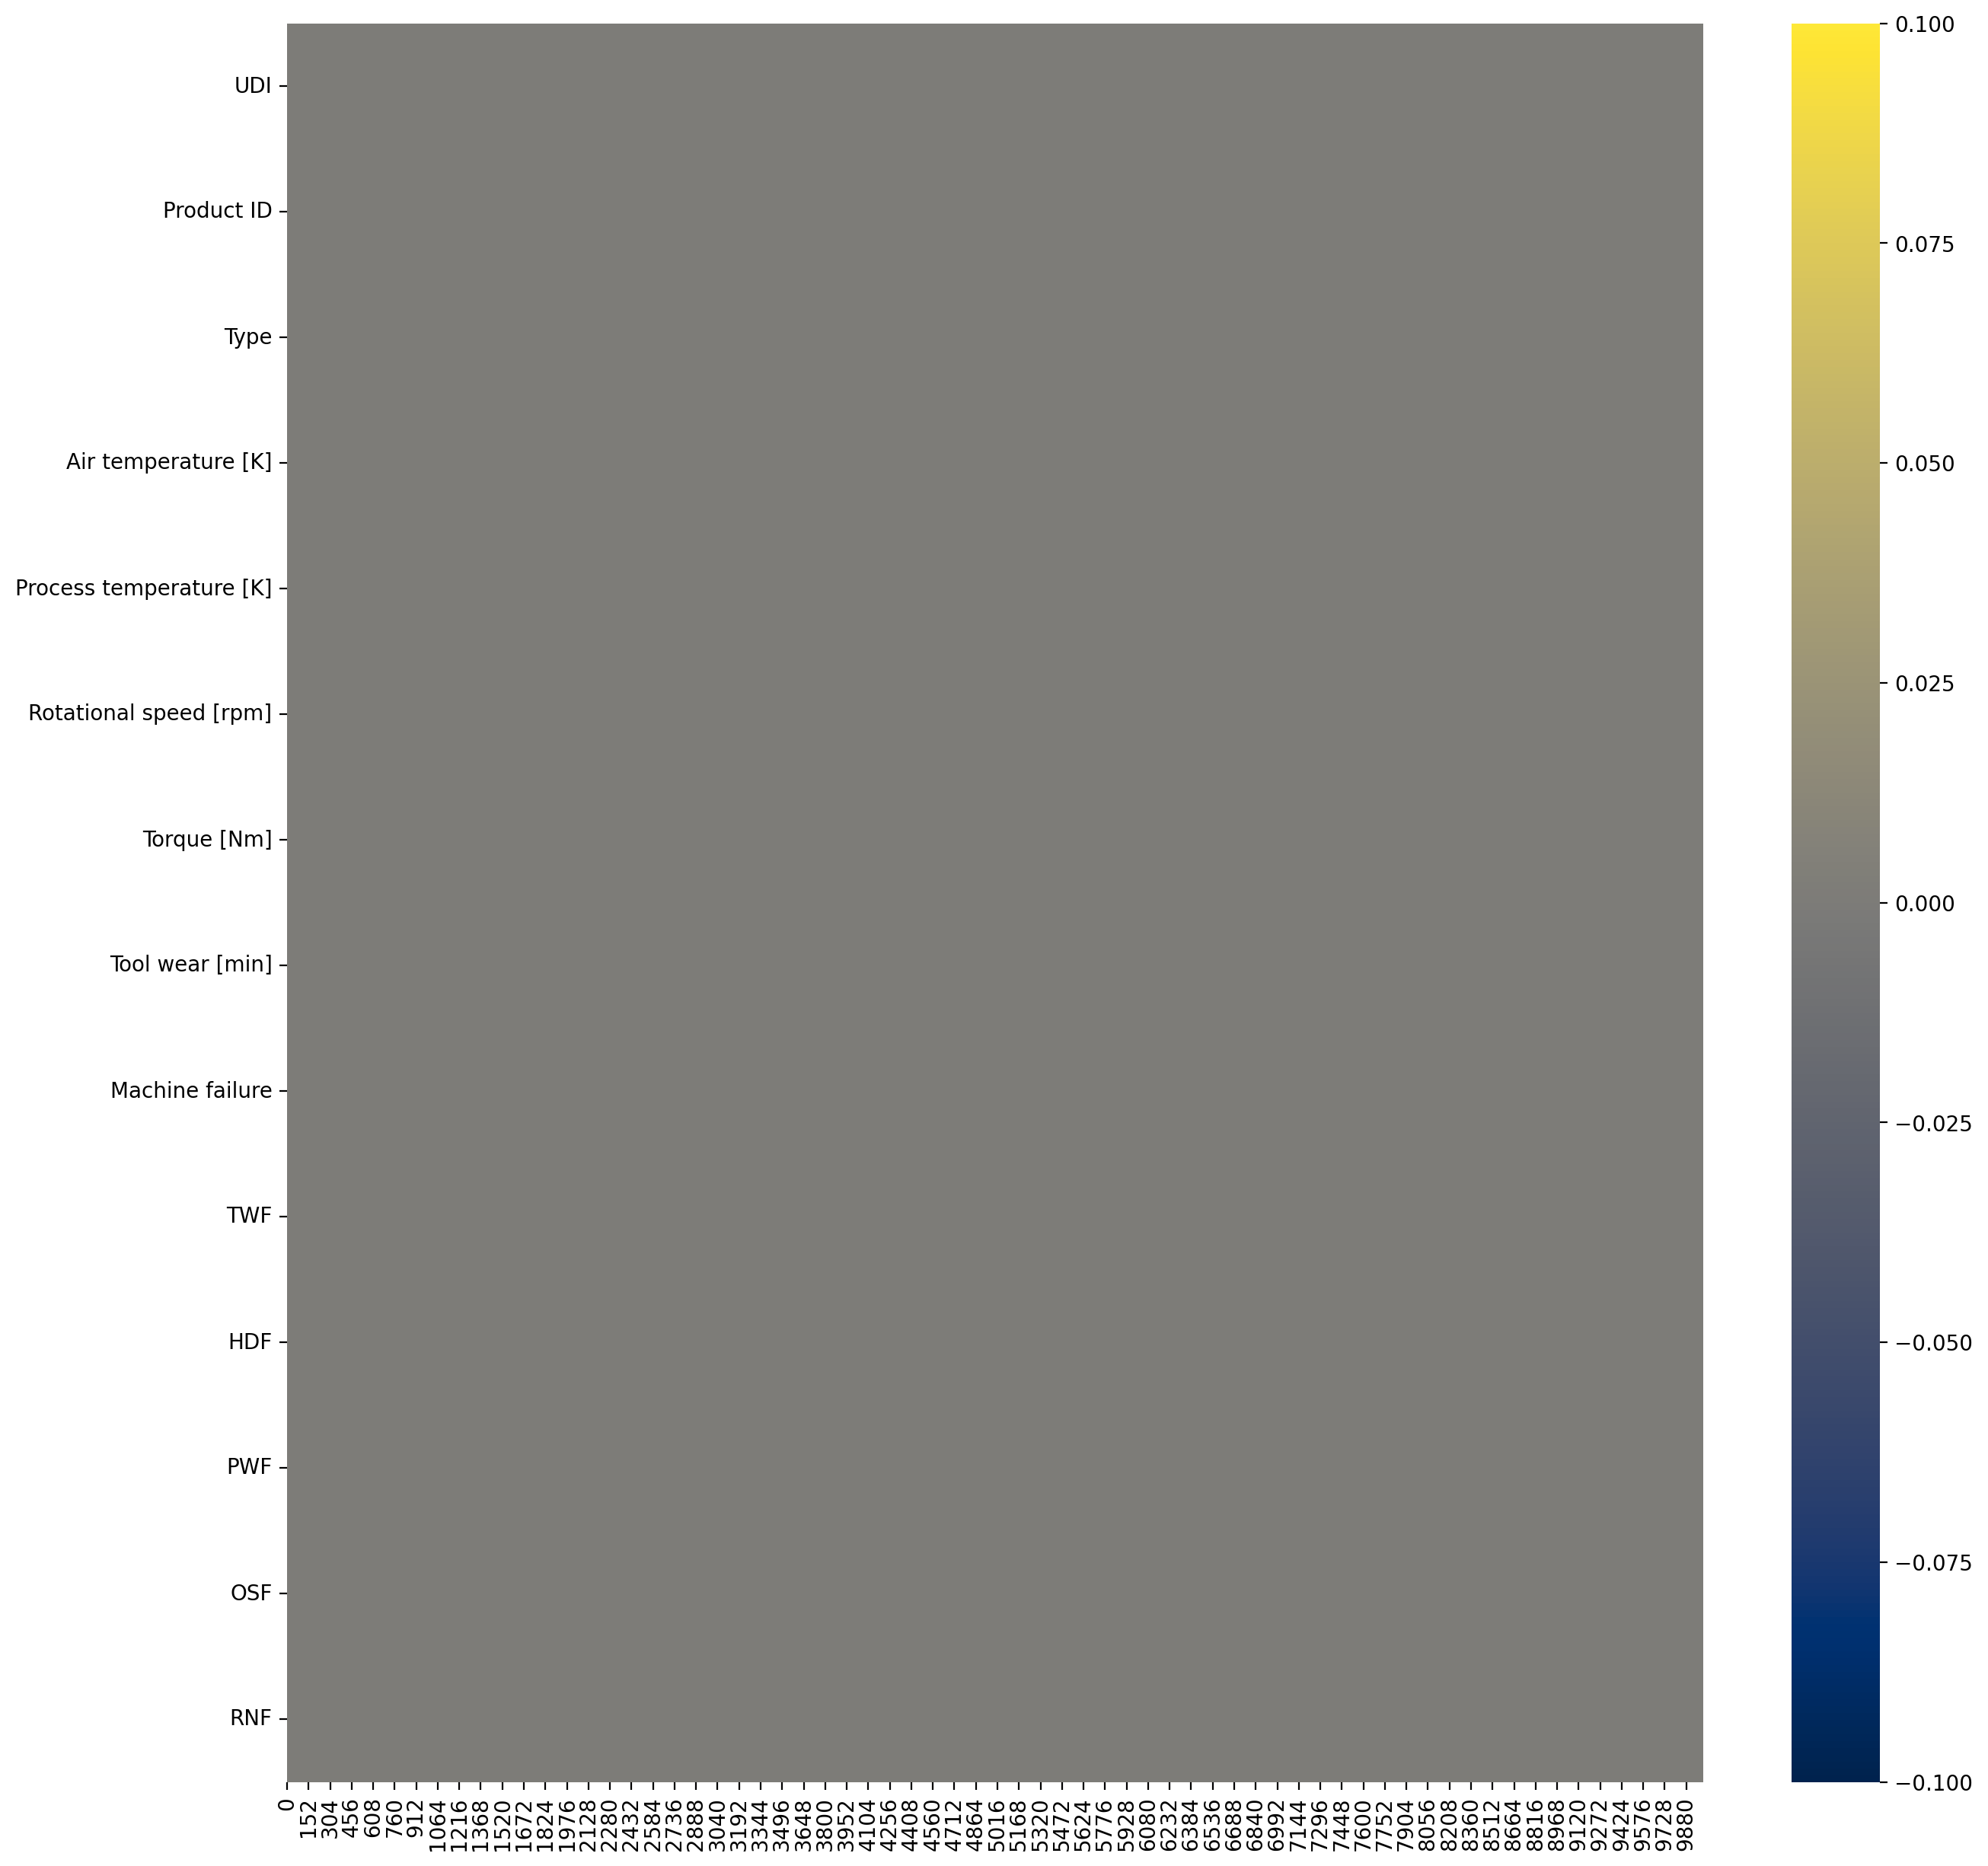

In [9]:
plt.figure(figsize=(15,15))
plot_kws={"s": 1}
sns.heatmap(df.isna().transpose(),
            cmap='cividis',
            linewidths=0.0,
           ).set_facecolor('white')

There are strongly correlated features namely process and air temperature. Torque and rotational speed are also strongly correlated. We can drop one of the temperatures, but the torque to rotational speed difference might be a indication of a failure, so we'll keep both.  

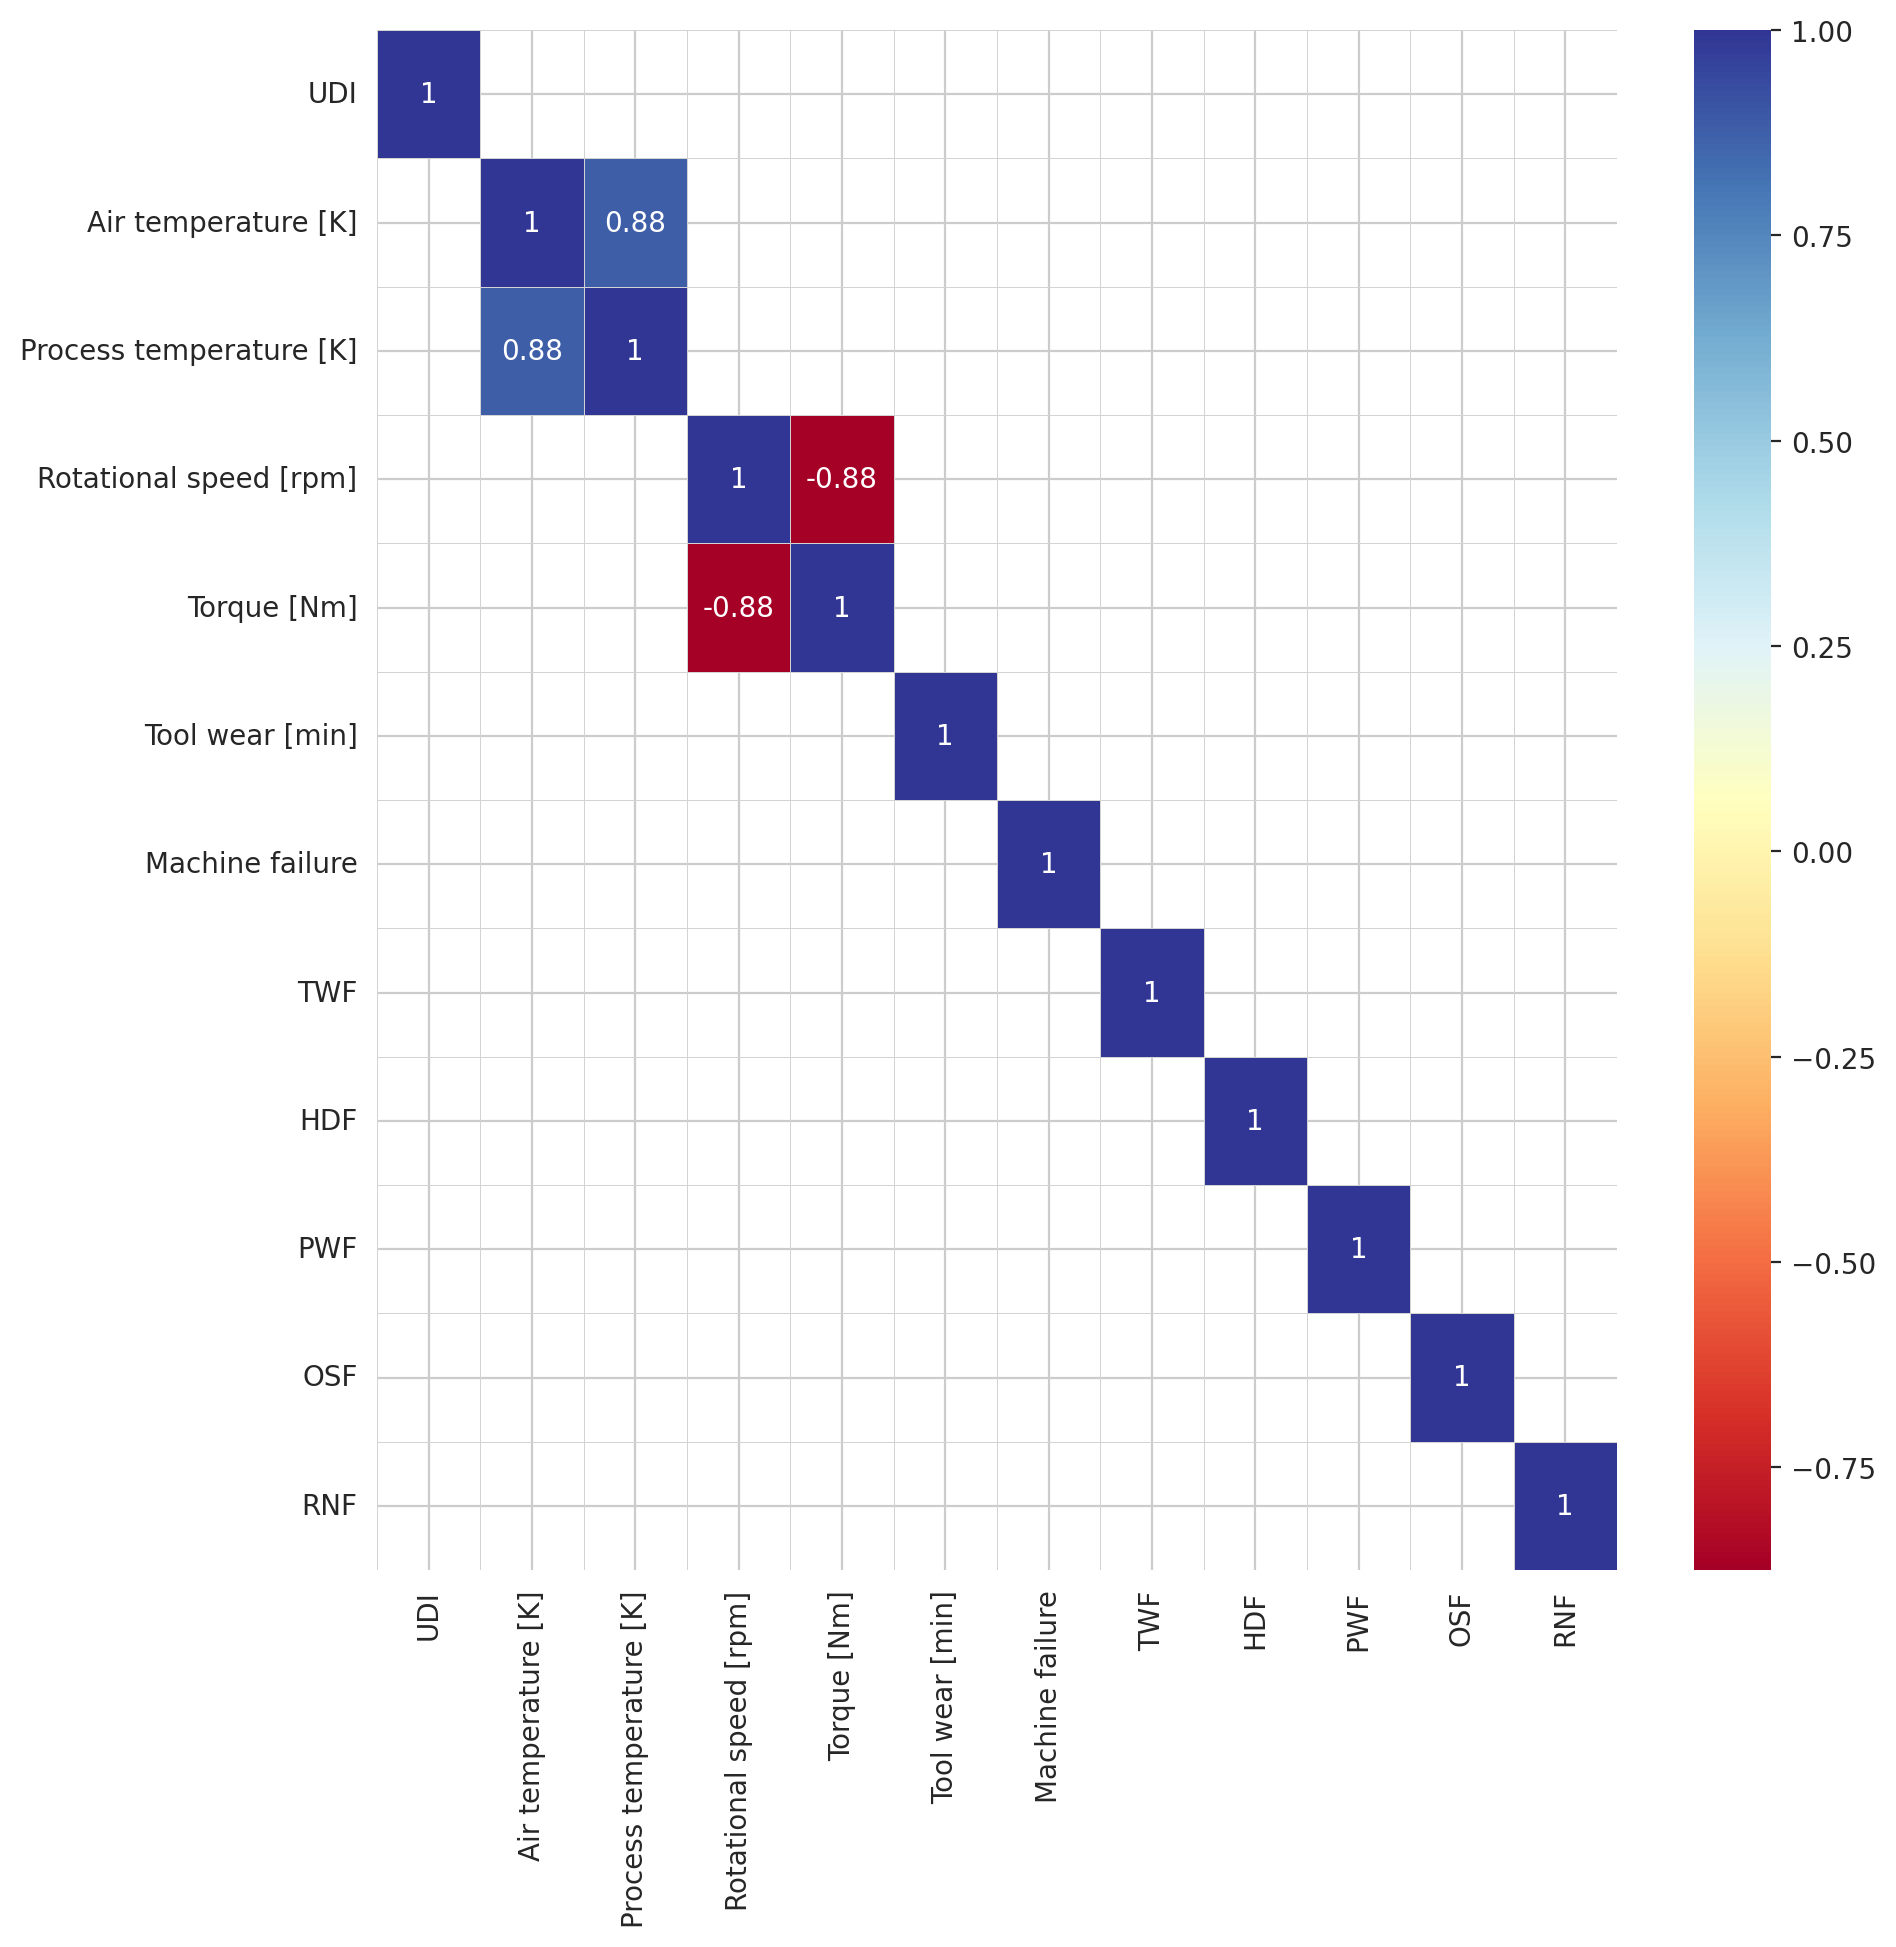

In [10]:
plt.figure(figsize=(10,10))
threshold = 0.80
sns.set_style("whitegrid", {"axes.facecolor": ".0"})
df_cluster2 = df.select_dtypes(include=np.number).corr()
mask = df_cluster2.where((abs(df_cluster2) >= threshold)).isna()
plot_kws={"s": 1}
sns.heatmap(df_cluster2,
            cmap='RdYlBu',
            annot=True,
            mask=mask,
            linewidths=0.2,
            linecolor='lightgrey').set_facecolor('white')

In [11]:
!pip install ydata_profiling

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.9/390.9 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 24.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 687.8/687.8 kB 25.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.8/104.8 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 62.5 MB/s eta 0:00:00
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27081 sha256=d612e6122cceeb1a64c452c68a92298a0dc78193648ca33494a0069bfb31f4a3
  Stored in directory: /root/.cache/pip/wheels/8d/55/1a/19cd535375ed1ede0c996405ebffe34b196d78e2d9545723a2
Successfully built htmlmin


In [12]:
from ydata_profiling import ProfileReport

The profiling report follows to look for outliers, missing values, and distributions. We can see that the data is imbalanced.

In [13]:
%%time
profile = ProfileReport(df,
                        title="Predictive Maintenance",
                        dataset={"description": "This profiling report was generated for Deepika Ambade"},
                        explorative=True,
                       )
profile

CPU times: user 37.7 ms, sys: 794 µs, total: 38.5 ms
Wall time: 187 ms


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Drop the indices as these have no predictive power

In [14]:
df.drop(['UDI','Product ID'],axis=1,inplace=True)

Drop the failure modes, as we're only interested whether something is a failure. I guess that you'll build a model for each failure mode if it comes down to that.

In [15]:
df.drop(['TWF','HDF','PWF','OSF','RNF'],axis=1,inplace=True)

Drop the type, as this dominates too strongly on type = L.

In [16]:
df.drop(['Type'],axis=1,inplace=True)

The remaining features

In [17]:
list(df)

['Air temperature [K]',
 'Process temperature [K]',
 'Rotational speed [rpm]',
 'Torque [Nm]',
 'Tool wear [min]',
 'Machine failure']

turn categorical information into numeric

In [18]:
df = pd.get_dummies(df,drop_first=True)

In [19]:
features = list(df.columns)

In [20]:
for feature in features:
    print(feature + " - " + str(len(df[df[feature].isna()])))

Air temperature [K] - 0
Process temperature [K] - 0
Rotational speed [rpm] - 0
Torque [Nm] - 0
Tool wear [min] - 0
Machine failure - 0


Just another confirmation of how badly imbalanced the data is. We'll need to oversample in this case to get a better prediction.

In [21]:
df_group = df.groupby(['Machine failure'])
df_group.count()

Air temperature [K]  Process temperature [K]  Rotational speed [rpm]  Torque [Nm]  Tool wear [min]
Machine failure                                                                                                    
0.0                             9661                     9661                    9661         9661             9661
1.0                              339                      339                     339          339              339

In [22]:
df[df['Machine failure'].isna()]

Empty DataFrame
Columns: [Air temperature [K], Process temperature [K], Rotational speed [rpm], Torque [Nm], Tool wear [min], Machine failure]
Index: []

<a id='3'></a>
# <p style="padding: 8px;color:white; display:fill;background-color:#555555; border-radius:5px; font-size:100%"> <b>Pre-processing and Feature Selection</b>

replace the missing numeric values with the mean

In [23]:
df_numeric.fillna(df_numeric.mean(),inplace=True)

for feature in features:
    try:
        df[feature].fillna(df[feature].mean(),inplace=True)
    except:
        try:
            df[feature].fillna(df[feature].mode(),inplace=True)
        except:
            pass

In [24]:
df.describe(include='all').T

count        mean         std     min     25%     50%     75%     max
Air temperature [K]      10000.0   300.00493    2.000259   295.3   298.3   300.1   301.5   304.5
Process temperature [K]  10000.0   310.00556    1.483734   305.7   308.8   310.1   311.1   313.8
Rotational speed [rpm]   10000.0  1538.77610  179.284096  1168.0  1423.0  1503.0  1612.0  2886.0
Torque [Nm]              10000.0    39.98691    9.968934     3.8    33.2    40.1    46.8    76.6
Tool wear [min]          10000.0   107.95100   63.654147     0.0    53.0   108.0   162.0   253.0
Machine failure          10000.0     0.03390    0.180981     0.0     0.0     0.0     0.0     1.0

# **UNIVARIATE ANALYSIS**
Perform a statistical univariate test to determine the best features. Product type L dominates this strongly.

In [25]:
# Feature Selection
from sklearn.feature_selection import SelectKBest, chi2

best_features = SelectKBest(score_func=chi2,k='all')

X = df.iloc[:,:-1]
y = df.iloc[:,-1]
fit = best_features.fit(X,y)

df_scores=pd.DataFrame(fit.scores_)
df_col=pd.DataFrame(X.columns)

feature_score=pd.concat([df_col,df_scores],axis=1)
feature_score.columns=['feature','score']
feature_score.sort_values(by=['score'],ascending=True,inplace=True)

fig = go.Figure(go.Bar(
            x=feature_score['score'][0:21],
            y=feature_score['feature'][0:21],
            orientation='h'))

fig.update_layout(title="Top 20 Features",
                  height=1200,
                  showlegend=False,
                 )

fig.show()

In [26]:

Selected_Features = []
import statsmodels.api as sm

def backward_regression(X, y, initial_list=[], threshold_out=0.5, verbose=True):
    """To select feature with Backward Stepwise Regression

    Args:
        X -- features values
        y -- target variable
        initial_list -- features header
        threshold_out -- pvalue threshold of features to drop
        verbose -- true to produce lots of logging output

    Returns:
        list of selected features for modeling
    """
    included = list(X.columns)
    while True:
        changed = False
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max()  # null if pvalues is empty
        if worst_pval > threshold_out:
            changed = True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print(f"worst_feature : {worst_feature}, {worst_pval} ")
        if not changed:
            break
    Selected_Features.append(included)
    print(f"\nSelected Features:\n{Selected_Features[0]}")


# Application of the backward regression function on our training data
backward_regression(X, y)


Selected Features:
['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']


In [27]:
X = df.iloc[:,:-1]
y = df.iloc[:,-1]

In [28]:
X.head()
feature_names = list(X.columns)
np.shape(X)

(10000, 5)

In [29]:
np.shape(X)

(10000, 5)

In [30]:
len(feature_names)

5

<a id='4'></a>
# <p style="padding: 8px;color:white; display:fill;background-color:#555555; border-radius:5px; font-size:100%"> <b>Modelling and Evaluation</b>

The data is too imbalanced, therefore we usually oversample. The randomoversampler performs better than SMOTE, but not oversampling performs the best. This is curious, but there are studies (check my discussion here: https://www.kaggle.com/competitions/autismdiagnosis/discussion/322588) that reckon that it is better not to oversample.

In [31]:
# import library
from imblearn.over_sampling import SMOTE, SVMSMOTE,RandomOverSampler
oversamp = RandomOverSampler(random_state=0)
# oversamp = SMOTE(n_jobs=-1)

In [32]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.2,
                                                    random_state = 0,
                                                    stratify=y)
# X_train,y_train = oversamp.fit_resample(X_train, y_train)

There are no distinct outliers, therefore a simple minmax scaler suffices.

In [33]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [34]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score,roc_auc_score,matthews_corrcoef
from sklearn.metrics import ConfusionMatrixDisplay # Import ConfusionMatrixDisplay instead of plot_confusion_matrix

import time
model_performance = pd.DataFrame(columns=['Accuracy','Recall','Precision','F1-Score','MCC score','time to train','time to predict','total time'])

<a id='4_1'></a>
## <p style="padding: 8px;color:white; display:fill;background-color:#aaaaaa; border-radius:5px; font-size:100%"> <b>Logistical Classification</b>

In [35]:
%%time
from sklearn.linear_model import LogisticRegression
start = time.time()
model = LogisticRegression().fit(X_train,y_train)
end_train = time.time()
y_predictions = model.predict(X_test) # These are the predictions from the test data.
end_predict = time.time()

CPU times: user 28.1 ms, sys: 35.3 ms, total: 63.5 ms
Wall time: 39.5 ms


In [36]:
accuracy = accuracy_score(y_test, y_predictions)
recall = recall_score(y_test, y_predictions, average='weighted')
precision = precision_score(y_test, y_predictions, average='weighted')
f1s = f1_score(y_test, y_predictions, average='weighted')
MCC = matthews_corrcoef(y_test, y_predictions)
# ROC_AUC = roc_auc_score(y_test, y_predictions, average='weighted')
ROC_AUC = roc_auc_score(y_test, model.predict_proba(X_test)[:,1], average='weighted')

print("Accuracy: "+ "{:.2%}".format(accuracy))
print("Recall: "+ "{:.2%}".format(recall))
print("Precision: "+ "{:.2%}".format(precision))
print("F1-Score: "+ "{:.2%}".format(f1s))
print("MCC: "+ "{:.2%}".format(MCC))
print("ROC AUC score: "+ "{:.2%}".format(ROC_AUC))
print("time to train: "+ "{:.2f}".format(end_train-start)+" s")
print("time to predict: "+"{:.2f}".format(end_predict-end_train)+" s")
print("total: "+"{:.2f}".format(end_predict-start)+" s")
model_performance.loc['Logistic'] = [accuracy, recall, precision, f1s,MCC,end_train-start,end_predict-end_train,end_predict-start]

Accuracy: 96.60%
Recall: 96.60%
Precision: 93.32%
F1-Score: 94.93%
MCC: 0.00%
ROC AUC score: 88.54%
time to train: 0.04 s
time to predict: 0.00 s
total: 0.04 s


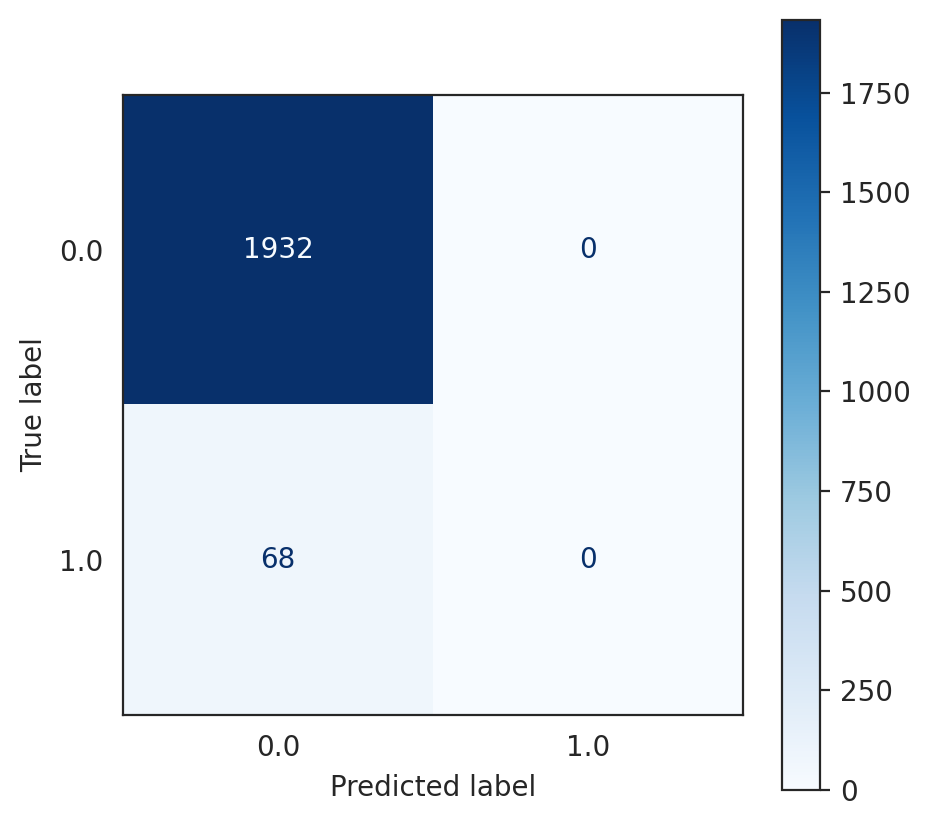

In [37]:
plt.rcParams['figure.figsize']=5,5
sns.set_style("white")

# Instead of plot_confusion_matrix, use ConfusionMatrixDisplay.from_estimator: because it was giving me error
from sklearn.metrics import ConfusionMatrixDisplay  # Ensure this is imported
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap=plt.cm.Blues)

plt.show()

<a id='4_3'></a>
## <p style="padding: 8px;color:white; display:fill;background-color:#aaaaaa; border-radius:5px; font-size:100%"> <b>Decision Tree</b>

In [38]:
%%time
from sklearn.tree import DecisionTreeClassifier
start = time.time()
model = DecisionTreeClassifier().fit(X_train,y_train)
end_train = time.time()
y_predictions = model.predict(X_test) # These are the predictions from the test data.
end_predict = time.time()

CPU times: user 33.4 ms, sys: 0 ns, total: 33.4 ms
Wall time: 34.9 ms


In [39]:
accuracy = accuracy_score(y_test, y_predictions)
recall = recall_score(y_test, y_predictions, average='weighted')
precision = precision_score(y_test, y_predictions, average='weighted')
f1s = f1_score(y_test, y_predictions, average='weighted')
MCC = matthews_corrcoef(y_test, y_predictions)
# ROC_AUC = roc_auc_score(y_test, y_predictions, average='weighted')
ROC_AUC = roc_auc_score(y_test, model.predict_proba(X_test)[:,1], average='weighted')

print("Accuracy: "+ "{:.2%}".format(accuracy))
print("Recall: "+ "{:.2%}".format(recall))
print("Precision: "+ "{:.2%}".format(precision))
print("F1-Score: "+ "{:.2%}".format(f1s))
print("MCC: "+ "{:.2%}".format(MCC))
print("ROC AUC score: "+ "{:.2%}".format(ROC_AUC))
print("time to train: "+ "{:.2f}".format(end_train-start)+" s")
print("time to predict: "+"{:.2f}".format(end_predict-end_train)+" s")
print("total: "+"{:.2f}".format(end_predict-start)+" s")
model_performance.loc['Decision Tree'] = [accuracy, recall, precision, f1s,MCC,end_train-start,end_predict-end_train,end_predict-start]

Accuracy: 97.75%
Recall: 97.75%
Precision: 97.62%
F1-Score: 97.67%
MCC: 63.58%
ROC AUC score: 79.68%
time to train: 0.03 s
time to predict: 0.00 s
total: 0.03 s


In [40]:
!pip install scikit-learn --upgrade

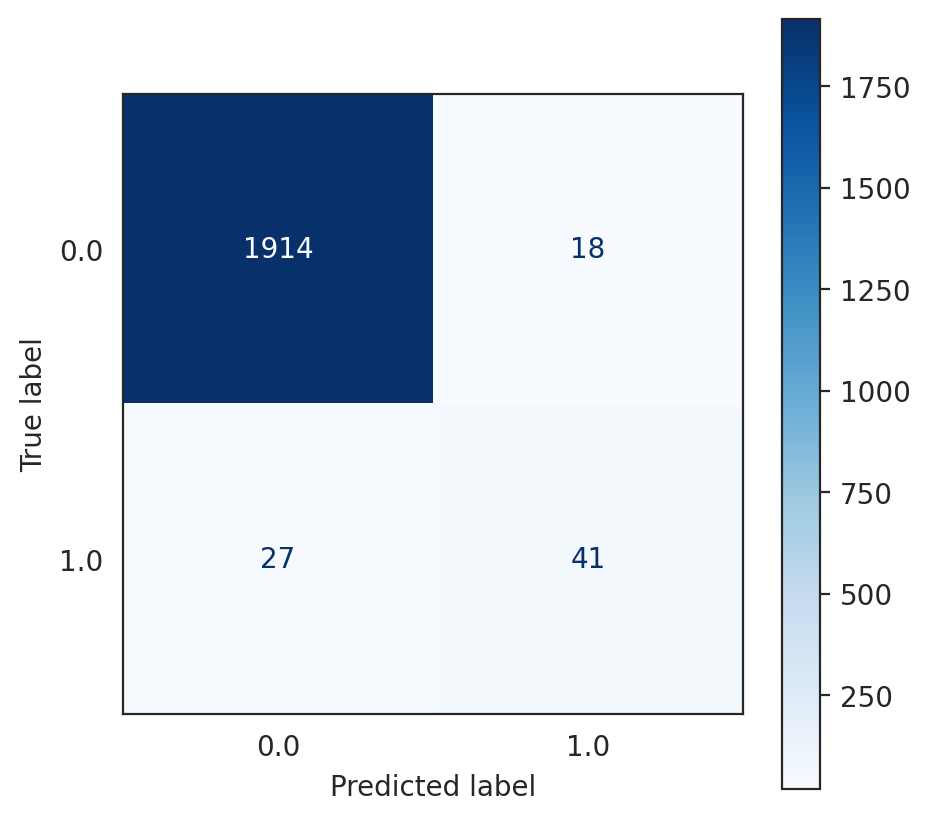

In [41]:
plt.rcParams['figure.figsize']=5,5
sns.set_style("white")

# Instead of plot_confusion_matrix, use ConfusionMatrixDisplay.from_estimator: because it was giving me error
from sklearn.metrics import ConfusionMatrixDisplay  # Ensure this is imported
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap=plt.cm.Blues)

plt.show()

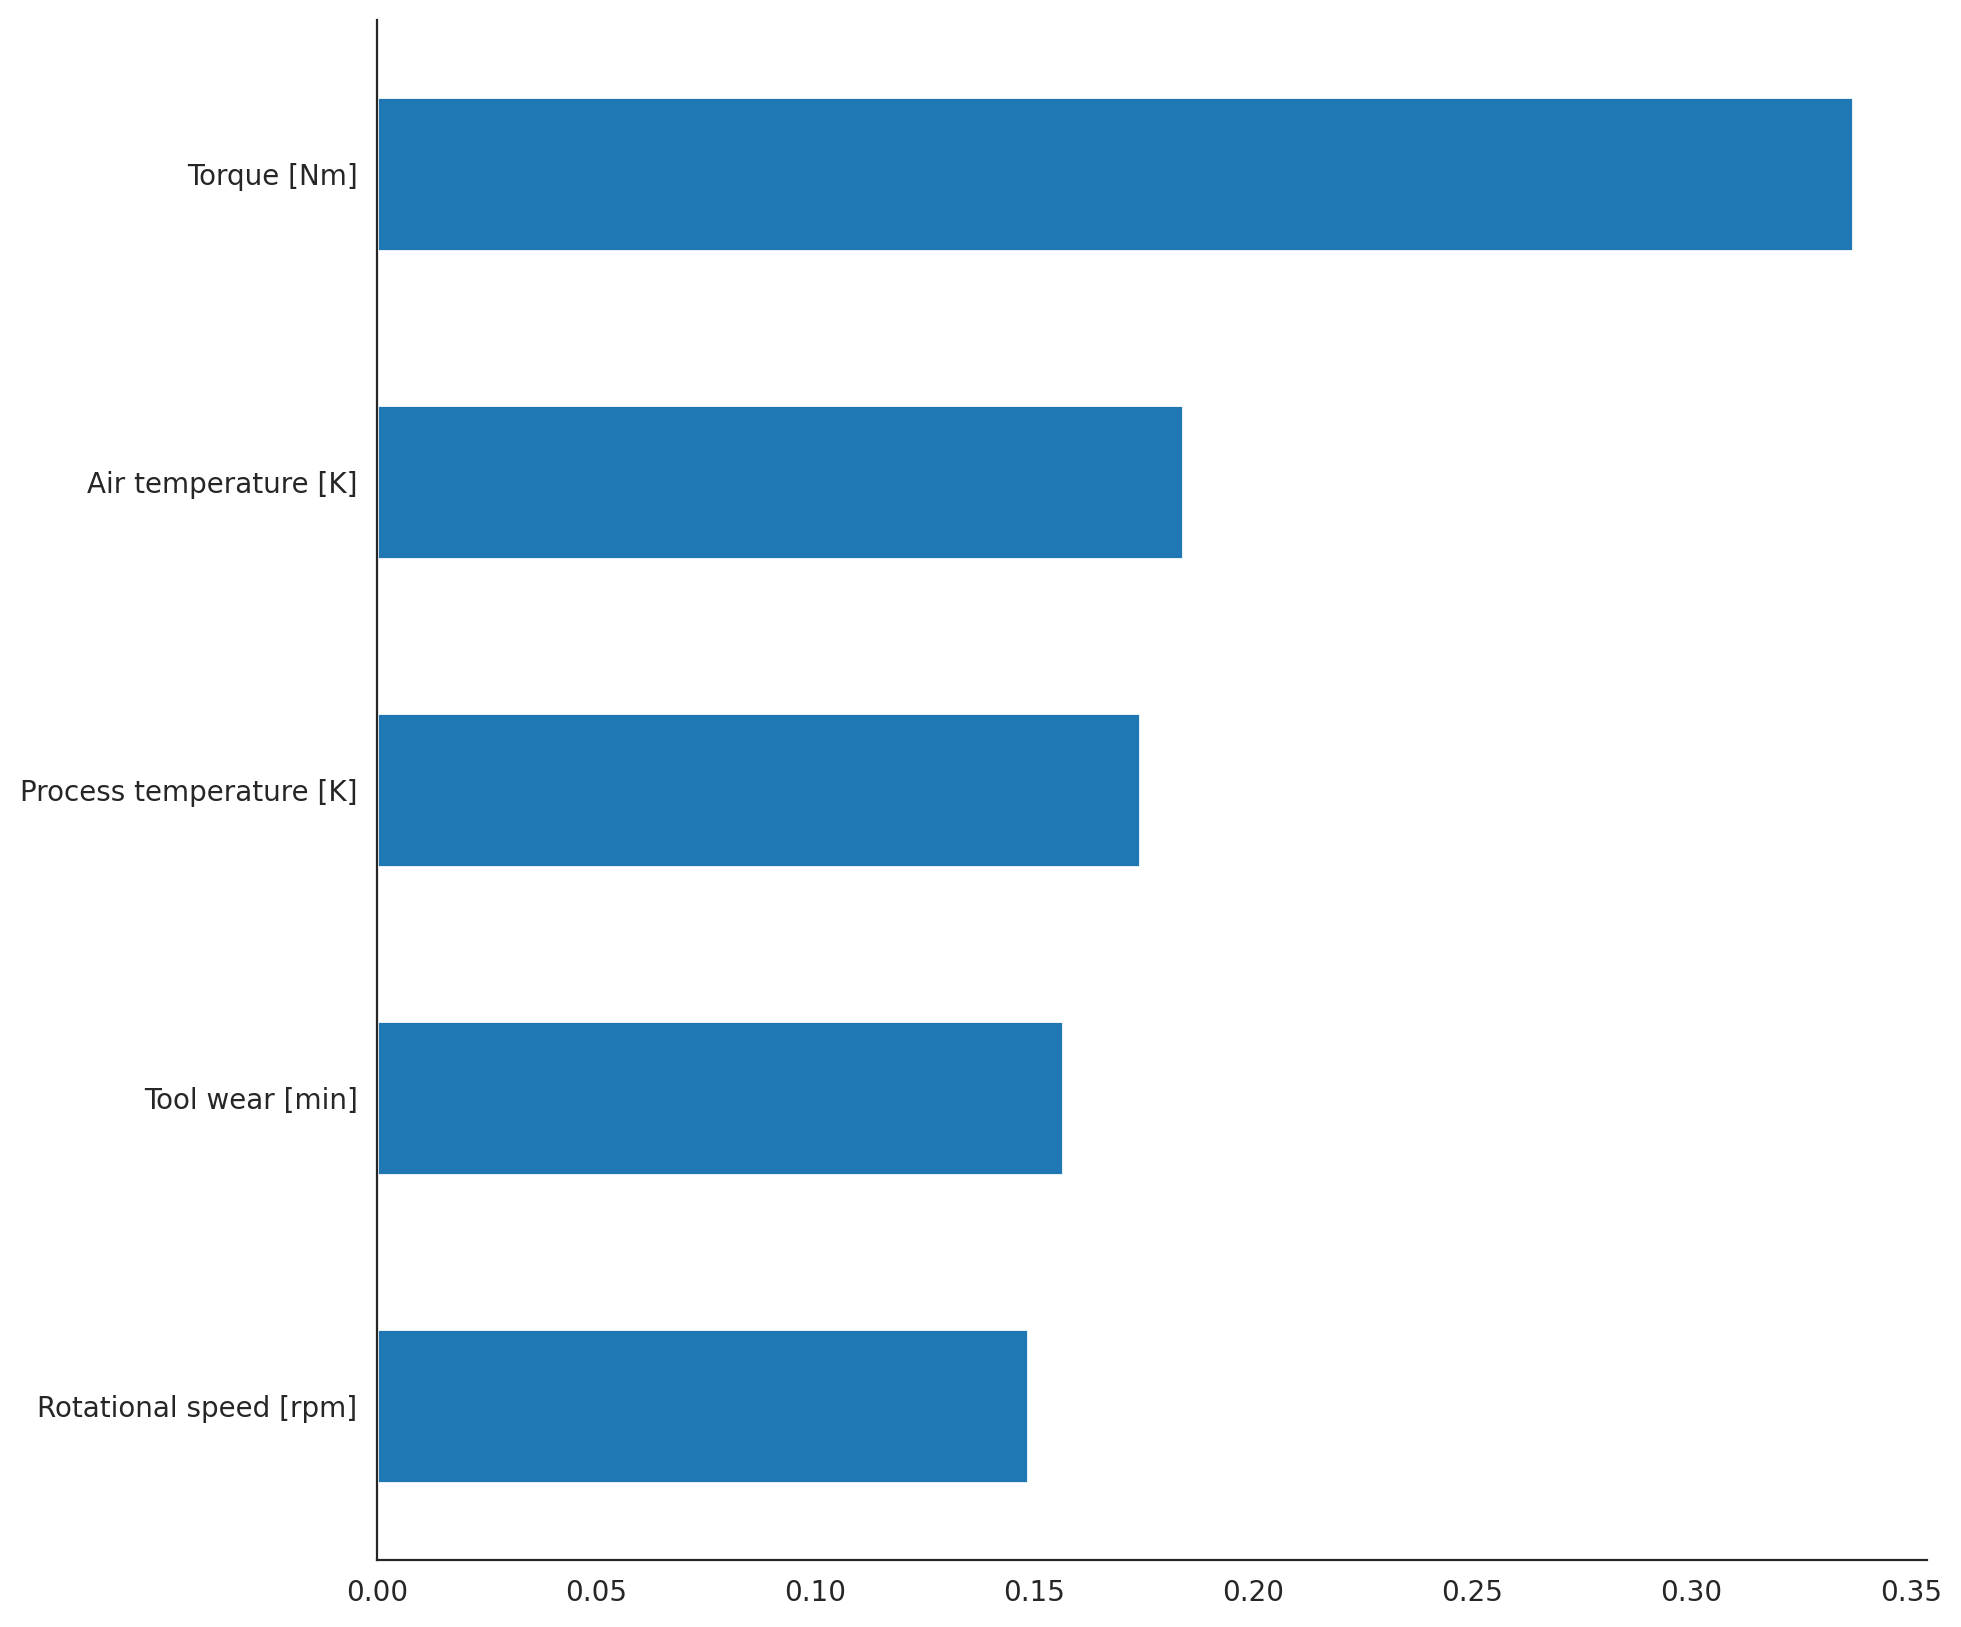

In [42]:
plt.rcParams['figure.figsize']=10,10
sns.set_style("white")
feat_importances = pd.Series(model.feature_importances_, index=feature_names)
feat_importances = feat_importances.groupby(level=0).mean()
feat_importances.nlargest(20).plot(kind='barh').invert_yaxis()
sns.despine()
plt.show()

<a id='4_5'></a>
## <p style="padding: 8px;color:white; display:fill;background-color:#aaaaaa; border-radius:5px; font-size:100%"> <b>Random Forest</b>

In [43]:
%%time
from sklearn.ensemble import RandomForestClassifier
start = time.time()
model = RandomForestClassifier(n_estimators = 100,n_jobs=-1,random_state=0,bootstrap=True,).fit(X_train,y_train)
end_train = time.time()
y_predictions = model.predict(X_test) # These are the predictions from the test data.
end_predict = time.time()

CPU times: user 1.42 s, sys: 9.69 ms, total: 1.43 s
Wall time: 1.6 s


In [44]:
accuracy = accuracy_score(y_test, y_predictions)
recall = recall_score(y_test, y_predictions, average='weighted')
precision = precision_score(y_test, y_predictions, average='weighted')
f1s = f1_score(y_test, y_predictions, average='weighted')
MCC = matthews_corrcoef(y_test, y_predictions)
# ROC_AUC = roc_auc_score(y_test, y_predictions, average='weighted')
ROC_AUC = roc_auc_score(y_test, model.predict_proba(X_test)[:,1], average='weighted')

print("Accuracy: "+ "{:.2%}".format(accuracy))
print("Recall: "+ "{:.2%}".format(recall))
print("Precision: "+ "{:.2%}".format(precision))
print("F1-Score: "+ "{:.2%}".format(f1s))
print("MCC: "+ "{:.2%}".format(MCC))
print("ROC AUC score: "+ "{:.2%}".format(ROC_AUC))
print("time to train: "+ "{:.2f}".format(end_train-start)+" s")
print("time to predict: "+"{:.2f}".format(end_predict-end_train)+" s")
print("total: "+"{:.2f}".format(end_predict-start)+" s")
model_performance.loc['Random Forest'] = [accuracy, recall, precision, f1s,MCC,end_train-start,end_predict-end_train,end_predict-start]

Accuracy: 98.55%
Recall: 98.55%
Precision: 98.46%
F1-Score: 98.44%
MCC: 75.55%
ROC AUC score: 95.42%
time to train: 1.56 s
time to predict: 0.04 s
total: 1.60 s


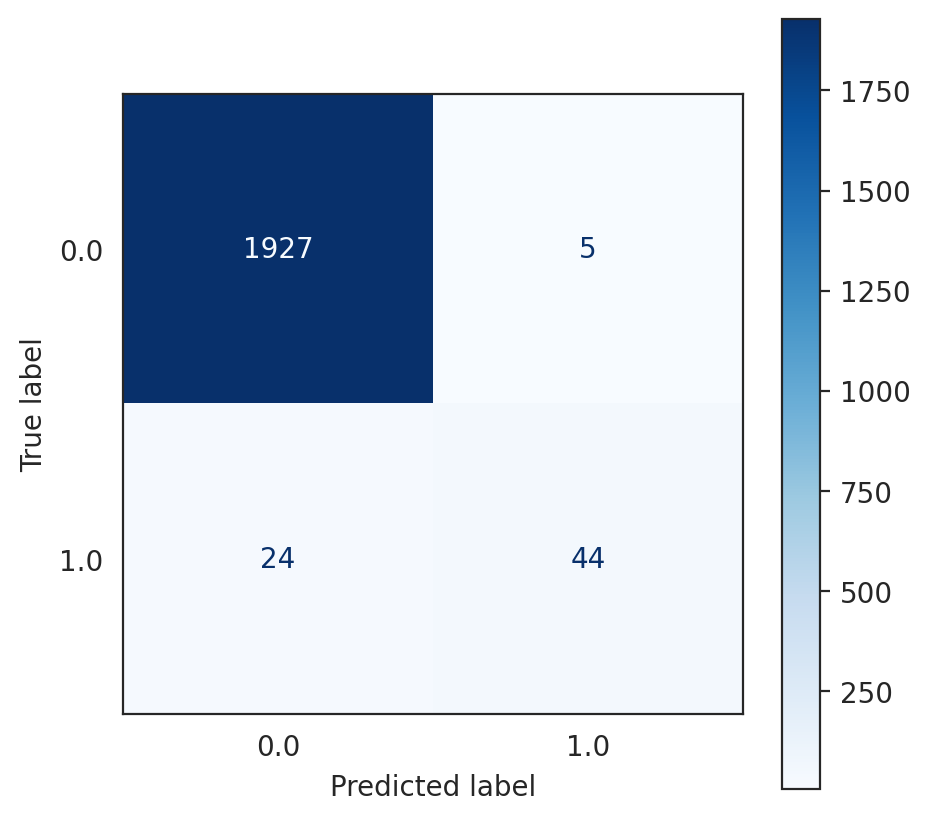

In [45]:
plt.rcParams['figure.figsize']=5,5
sns.set_style("white")

# Instead of plot_confusion_matrix, use ConfusionMatrixDisplay.from_estimator: because it was giving me error
from sklearn.metrics import ConfusionMatrixDisplay  # Ensure this is imported
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap=plt.cm.Blues)

plt.show()

<a id='4_6'></a>
## <p style="padding: 8px;color:white; display:fill;background-color:#aaaaaa; border-radius:5px; font-size:100%"> <b>Gradient Boosting Classifier</b>

In [46]:
%%time
from sklearn.ensemble import GradientBoostingClassifier
start = time.time()
model = GradientBoostingClassifier().fit(X_train,y_train)
end_train = time.time()
y_predictions = model.predict(X_test) # These are the predictions from the test data.
end_predict = time.time()

CPU times: user 1.14 s, sys: 856 µs, total: 1.14 s
Wall time: 1.16 s


In [47]:
accuracy = accuracy_score(y_test, y_predictions)
recall = recall_score(y_test, y_predictions, average='weighted')
precision = precision_score(y_test, y_predictions, average='weighted')
f1s = f1_score(y_test, y_predictions, average='weighted')
MCC = matthews_corrcoef(y_test, y_predictions)
# ROC_AUC = roc_auc_score(y_test, y_predictions, average='weighted')
ROC_AUC = roc_auc_score(y_test, model.predict_proba(X_test)[:,1], average='weighted')

print("Accuracy: "+ "{:.2%}".format(accuracy))
print("Recall: "+ "{:.2%}".format(recall))
print("Precision: "+ "{:.2%}".format(precision))
print("F1-Score: "+ "{:.2%}".format(f1s))
print("MCC: "+ "{:.2%}".format(MCC))
print("ROC AUC score: "+ "{:.2%}".format(ROC_AUC))
print("time to train: "+ "{:.2f}".format(end_train-start)+" s")
print("time to predict: "+"{:.2f}".format(end_predict-end_train)+" s")
print("total: "+"{:.2f}".format(end_predict-start)+" s")
model_performance.loc['Gradient Boosting Classifier'] = [accuracy, recall, precision, f1s,MCC,end_train-start,end_predict-end_train,end_predict-start]

Accuracy: 98.60%
Recall: 98.60%
Precision: 98.54%
F1-Score: 98.47%
MCC: 76.26%
ROC AUC score: 96.42%
time to train: 1.16 s
time to predict: 0.00 s
total: 1.16 s


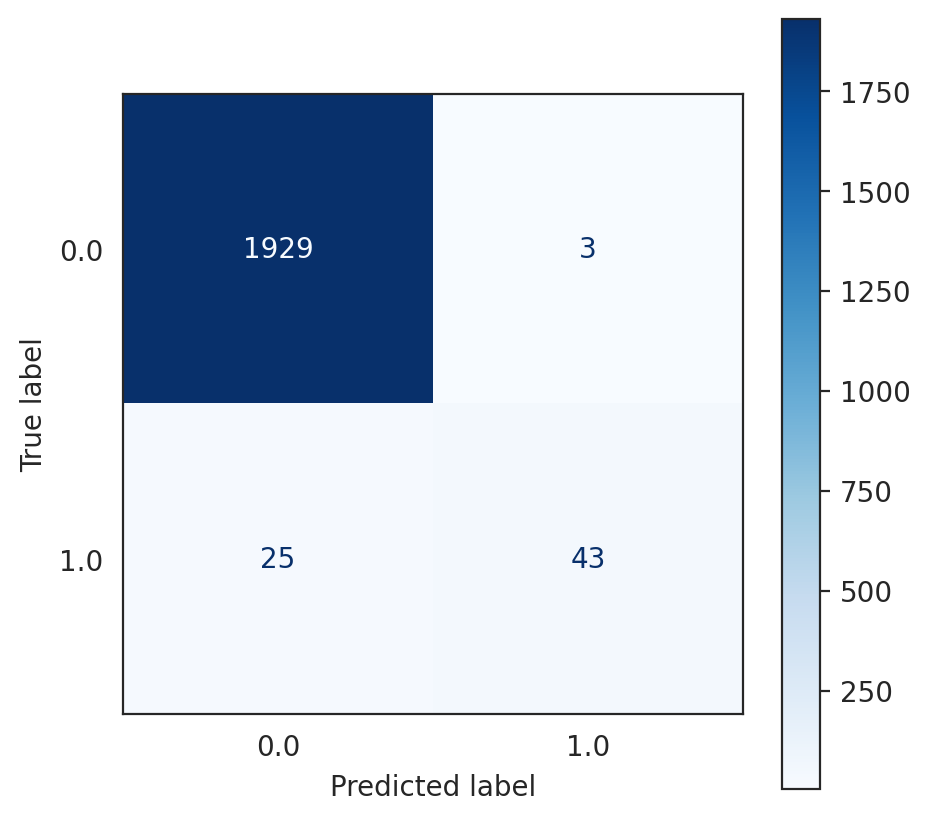

In [48]:
plt.rcParams['figure.figsize']=5,5
sns.set_style("white")

# Instead of plot_confusion_matrix, use ConfusionMatrixDisplay.from_estimator: because it was giving me error
from sklearn.metrics import ConfusionMatrixDisplay  # Ensure this is imported
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap=plt.cm.Blues)

plt.show()

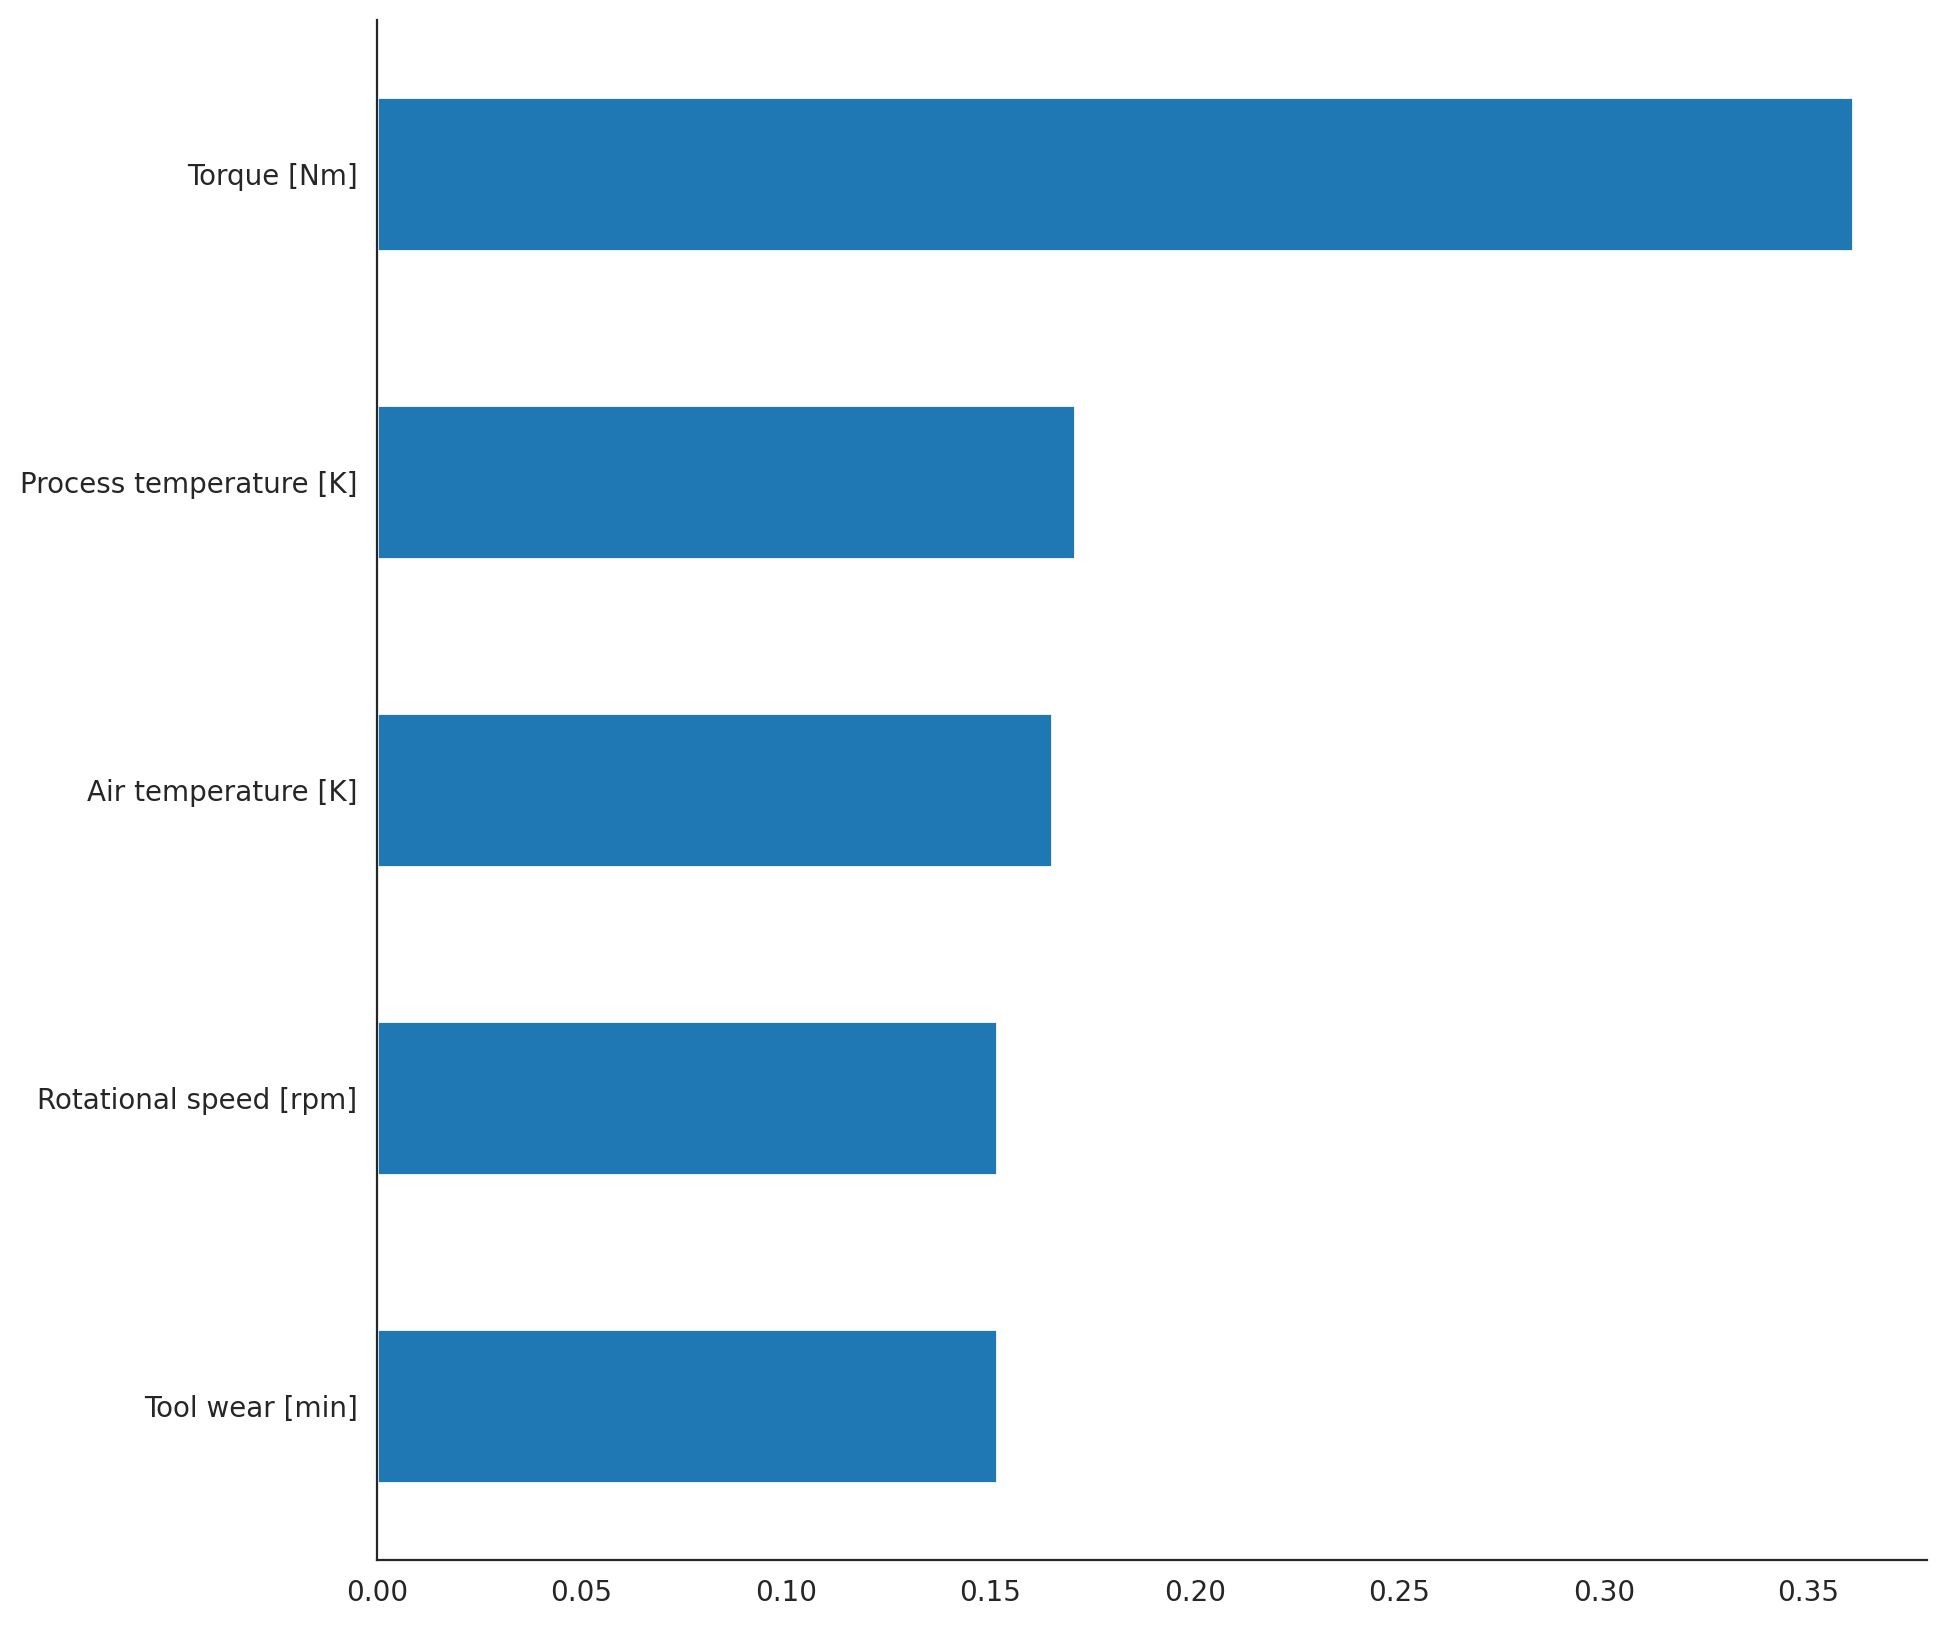

In [49]:
plt.rcParams['figure.figsize']=10,10
sns.set_style("white")
feat_importances = pd.Series(model.feature_importances_, index=feature_names)
feat_importances = feat_importances.groupby(level=0).mean()
feat_importances.nlargest(20).plot(kind='barh').invert_yaxis()
sns.despine()
plt.show()

**Types of Perceptrons**

### **1. Single-Layer, Single Perceptron**
A single perceptron in a single-layer network consists of only one neuron. It processes inputs and produces an output using a simple activation function like the step function. This type of perceptron is used for binary classification of linearly separable data, such as logic gates (AND, OR). However, it cannot solve non-linearly separable problems like XOR.

**Key Features:**
- Only one neuron
- Used for simple binary classification
- Cannot handle non-linearly separable data
- Typically uses a step function or sigmoid activation

**Use Case:** Simple binary classification tasks, such as AND/OR logic gates.

---

### **2. Single-Layer, Multi Perceptron**
A single-layer perceptron with multiple neurons operates in parallel, allowing classification of multiple categories. It extends the single perceptron by introducing multiple output neurons. This enables the model to handle multi-class problems where the output is not just binary but has multiple possible labels.

**Key Features:**
- Single layer with multiple neurons
- Used for multi-class classification
- Typically employs softmax activation for probability distribution
- Can process multiple features simultaneously

**Use Case:** Multi-class classification problems, such as digit recognition or document classification.

---

### **3. Multi-Layer, Multi Perceptron (MLP)**
A multi-layer perceptron (MLP) consists of multiple layers, including one or more hidden layers. This structure enables the model to learn complex, non-linear patterns and solve problems that single-layer perceptrons cannot. MLPs use backpropagation for training, allowing them to adjust weights based on errors and improve accuracy.

**Key Features:**
- Multiple layers (input, hidden, and output layers)
- Can learn non-linear relationships
- Uses backpropagation for training
- Common activation functions include ReLU, sigmoid, and tanh

**Use Case:** Used in deep learning applications such as image recognition, speech processing, and financial forecasting.

---

### **Comparison Table**

| Type | Layers | Neurons | Use Case |
|-------|--------|---------|----------------|
| **Single-Layer, Single Perceptron** | 1 | 1 | Binary classification (AND, OR) |
| **Single-Layer, Multi Perceptron** | 1 | Multiple | Multi-class classification |
| **Multi-Layer, Multi Perceptron (MLP)** | Multiple | Multiple | Complex problems (XOR, image recognition) |

Each perceptron type has its strengths and limitations. While a single-layer perceptron is fast and simple, multi-layer perceptrons are essential for solving real-world AI problems.



<a id='4_7'></a>
## <p style="padding: 8px;color:white; display:fill;background-color:#aaaaaa; border-radius:5px; font-size:100%"> <b>Neural Network MLP</b>

Iteration 1, loss = 1.33785343
Iteration 2, loss = 1.03678191
Iteration 3, loss = 0.73587741
Iteration 4, loss = 0.49490057
Iteration 5, loss = 0.34234429
Iteration 6, loss = 0.26013528
Iteration 7, loss = 0.21737670
Iteration 8, loss = 0.19438915
Iteration 9, loss = 0.18142951
Iteration 10, loss = 0.17358233
Iteration 11, loss = 0.16874016
Iteration 12, loss = 0.16562376
Iteration 13, loss = 0.16357307
Iteration 14, loss = 0.16213058
Iteration 15, loss = 0.16115644
Iteration 16, loss = 0.16046498
Iteration 17, loss = 0.15995540
Iteration 18, loss = 0.15957506
Iteration 19, loss = 0.15929475
Iteration 20, loss = 0.15908139
Iteration 21, loss = 0.15890318
Iteration 22, loss = 0.15875678
Iteration 23, loss = 0.15864294
Iteration 24, loss = 0.15852923
Iteration 25, loss = 0.15843633
Iteration 26, loss = 0.15835456
Iteration 27, loss = 0.15827260
Iteration 28, loss = 0.15820141
Iteration 29, loss = 0.15813080
Iteration 30, loss = 0.15805722
Iteration 31, loss = 0.15799059
Iteration 32, los

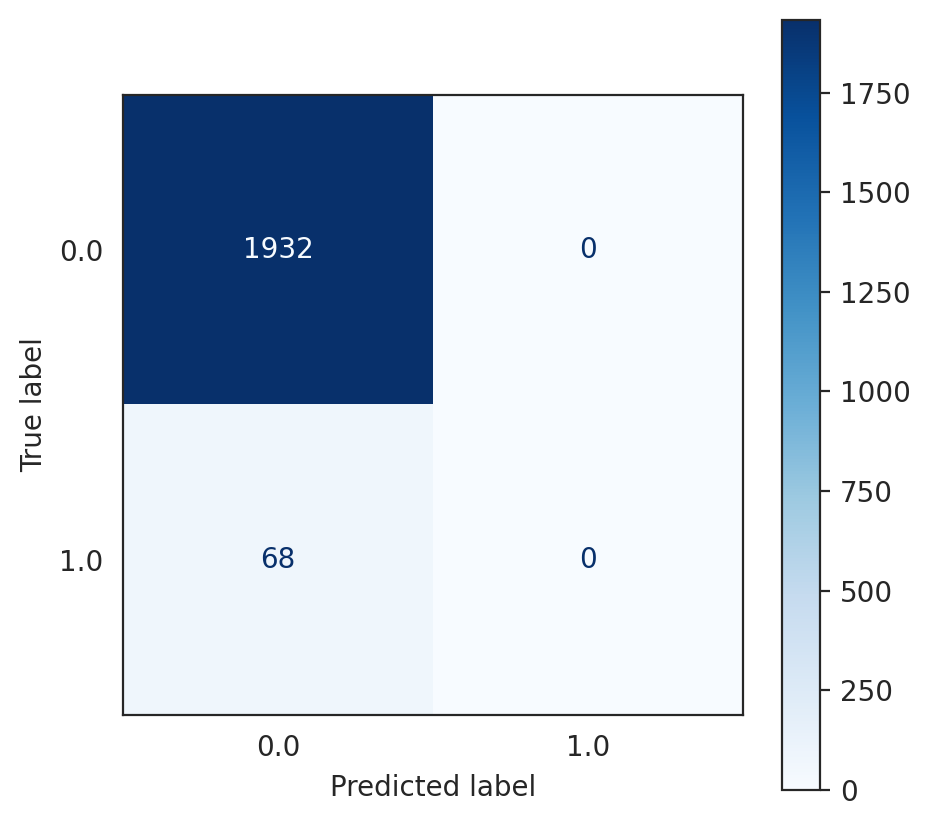

In [58]:
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (accuracy_score, recall_score, precision_score,
                             f1_score, matthews_corrcoef, roc_auc_score,
                             ConfusionMatrixDisplay)

# Assuming X_train, X_test, y_train, y_test are already defined

# Parameters
max_epochs = 1000  # Number of epochs

start = time.time()
model = MLPClassifier(
    hidden_layer_sizes=(1,),  # Single-layer, single perceptron
    activation='relu',  # relu activation function
    solver='sgd',  # Stochastic gradient descent solver
    max_iter=max_epochs,  # Maximum number of iterations (epochs)
    random_state=0,
    verbose=True  # Enables logging of training progress
)

# Training the model
model.fit(X_train, y_train)
end_train = time.time()

# Predictions
y_predictions = model.predict(X_test)
end_predict = time.time()

# Metrics Calculation
accuracy = accuracy_score(y_test, y_predictions)
recall = recall_score(y_test, y_predictions, average='weighted')
precision = precision_score(y_test, y_predictions, average='weighted')
f1s = f1_score(y_test, y_predictions, average='weighted')
MCC = matthews_corrcoef(y_test, y_predictions)

# Handle potential error for roc_auc_score if predict_proba isn't available.
try:
    ROC_AUC = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1], average='weighted')
except AttributeError:
    print("Warning: predict_proba not available for ROC AUC calculation. Using default value.")
    ROC_AUC = 0  # Or handle differently

# Print results
print("Epochs trained:", model.n_iter_)
print("Accuracy:", "{:.2%}".format(accuracy))
print("Recall:", "{:.2%}".format(recall))
print("Precision:", "{:.2%}".format(precision))
print("F1-Score:", "{:.2%}".format(f1s))
print("MCC:", "{:.2%}".format(MCC))
print("ROC AUC score:", "{:.2%}".format(ROC_AUC))
print("Time to train:", "{:.2f}".format(end_train - start), "s")
print("Time to predict:", "{:.2f}".format(end_predict - end_train), "s")
print("Total time:", "{:.2f}".format(end_predict - start), "s")

# Confusion Matrix
plt.rcParams['figure.figsize'] = (5, 5)
sns.set_style("white")
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap=plt.cm.Blues)
plt.show()


after 36 epochs, training loss didnt improve, so best number of epochs for this is

solution: adjusting tol, increasing max_iter, or changing the optimizer to improve convergence.

Iteration 1, loss = 1.33785343
Iteration 2, loss = 1.03678191
Iteration 3, loss = 0.73587741
Iteration 4, loss = 0.49490057
Iteration 5, loss = 0.34234429
Iteration 6, loss = 0.26013528
Iteration 7, loss = 0.21737670
Iteration 8, loss = 0.19438915
Iteration 9, loss = 0.18142951
Iteration 10, loss = 0.17358233
Iteration 11, loss = 0.16874016
Iteration 12, loss = 0.16562376
Iteration 13, loss = 0.16357307
Iteration 14, loss = 0.16213058
Iteration 15, loss = 0.16115644
Iteration 16, loss = 0.16046498
Iteration 17, loss = 0.15995540
Iteration 18, loss = 0.15957506
Iteration 19, loss = 0.15929475
Iteration 20, loss = 0.15908139
Iteration 21, loss = 0.15890318
Iteration 22, loss = 0.15875678
Iteration 23, loss = 0.15864294
Iteration 24, loss = 0.15852923
Iteration 25, loss = 0.15843633
Iteration 26, loss = 0.15835456
Iteration 27, loss = 0.15827260
Iteration 28, loss = 0.15820141
Iteration 29, loss = 0.15813080
Iteration 30, loss = 0.15805722
Iteration 31, loss = 0.15799059
Iteration 32, los

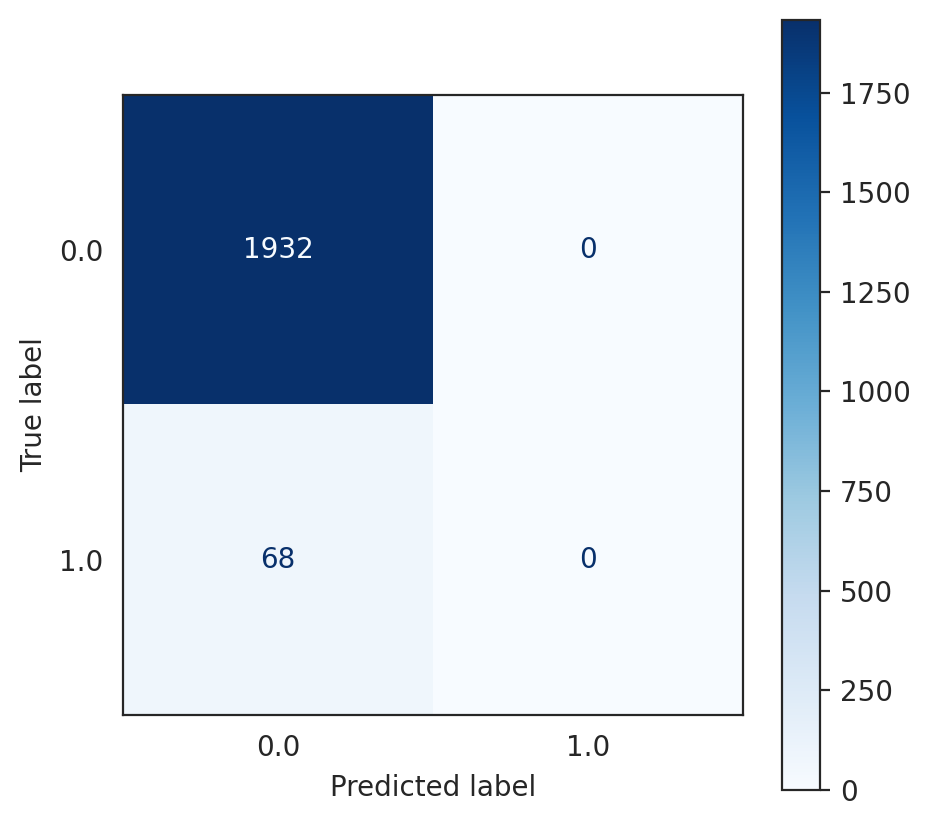

In [59]:
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, matthews_corrcoef, roc_auc_score
from sklearn.metrics import ConfusionMatrixDisplay

# Assuming X_train, X_test, y_train, y_test are already defined

start = time.time()
model = MLPClassifier(hidden_layer_sizes=(1,),  # Single-layer, single perceptron
                      activation='relu',  # ReLU activation function
                      solver='sgd',  # Stochastic gradient descent solver
                      max_iter=500,  # Increased max_iter to allow more epochs
                      tol=1e-6,  # Lower tolerance for better convergence
                      random_state=0,
                      verbose=True).fit(X_train, y_train)
end_train = time.time()

# Predictions
y_predictions = model.predict(X_test)
end_predict = time.time()

# Metrics Calculation
accuracy = accuracy_score(y_test, y_predictions)
recall = recall_score(y_test, y_predictions, average='weighted')
precision = precision_score(y_test, y_predictions, average='weighted')
f1s = f1_score(y_test, y_predictions, average='weighted')
MCC = matthews_corrcoef(y_test, y_predictions)

# Handle potential error for roc_auc_score if predict_proba isn't available.
try:
    ROC_AUC = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1], average='weighted')
except AttributeError:
    print("Warning: predict_proba not available for ROC AUC calculation. Using default value.")
    ROC_AUC = 0  # Default value

# Display Results
print(f"Epochs trained: {model.n_iter_}")
print("Accuracy:", "{:.2%}".format(accuracy))
print("Recall:", "{:.2%}".format(recall))
print("Precision:", "{:.2%}".format(precision))
print("F1-Score:", "{:.2%}".format(f1s))
print("MCC:", "{:.2%}".format(MCC))
print("ROC AUC score:", "{:.2%}".format(ROC_AUC))
print("Time to train:", "{:.2f}".format(end_train - start), "s")
print("Time to predict:", "{:.2f}".format(end_predict - end_train), "s")
print("Total time:", "{:.2f}".format(end_predict - start), "s")

# Confusion Matrix
plt.rcParams['figure.figsize'] = (5, 5)
sns.set_style("white")
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap=plt.cm.Blues)
plt.show()


The 500-epoch model significantly improved the **ROC AUC score (78.21% vs. 30.72%)** but took **8.63s vs. 0.63s** to train, with all other metrics remaining the same. The 35-epoch model trained much faster but failed to generalize well in distinguishing between classes.

**Single layer Multi Perceptron**

Some suggestions:

max_iter (Epochs)

1000 (Default)	Best for complex problems or convergence issues

500	Moderate training time, usually enough for good results

200	If you want faster training (but risk underfitting)

50-100	Quick testing to check model setup

Iteration 1, loss = 1.01459824
Iteration 2, loss = 0.74707858
Iteration 3, loss = 0.51535057
Iteration 4, loss = 0.36167164
Iteration 5, loss = 0.27497694
Iteration 6, loss = 0.22958182
Iteration 7, loss = 0.20510396
Iteration 8, loss = 0.19164533
Iteration 9, loss = 0.18390211
Iteration 10, loss = 0.17933806
Iteration 11, loss = 0.17662463
Iteration 12, loss = 0.17495518
Iteration 13, loss = 0.17383432
Iteration 14, loss = 0.17311606
Iteration 15, loss = 0.17253308
Iteration 16, loss = 0.17206980
Iteration 17, loss = 0.17166279
Iteration 18, loss = 0.17128413
Iteration 19, loss = 0.17092171
Iteration 20, loss = 0.17054882
Iteration 21, loss = 0.17020193
Iteration 22, loss = 0.16981443
Iteration 23, loss = 0.16943476
Iteration 24, loss = 0.16905960
Iteration 25, loss = 0.16867539
Iteration 26, loss = 0.16831041
Iteration 27, loss = 0.16790041
Iteration 28, loss = 0.16752347
Iteration 29, loss = 0.16712763
Iteration 30, loss = 0.16674319
Iteration 31, loss = 0.16633367
Iteration 32, los

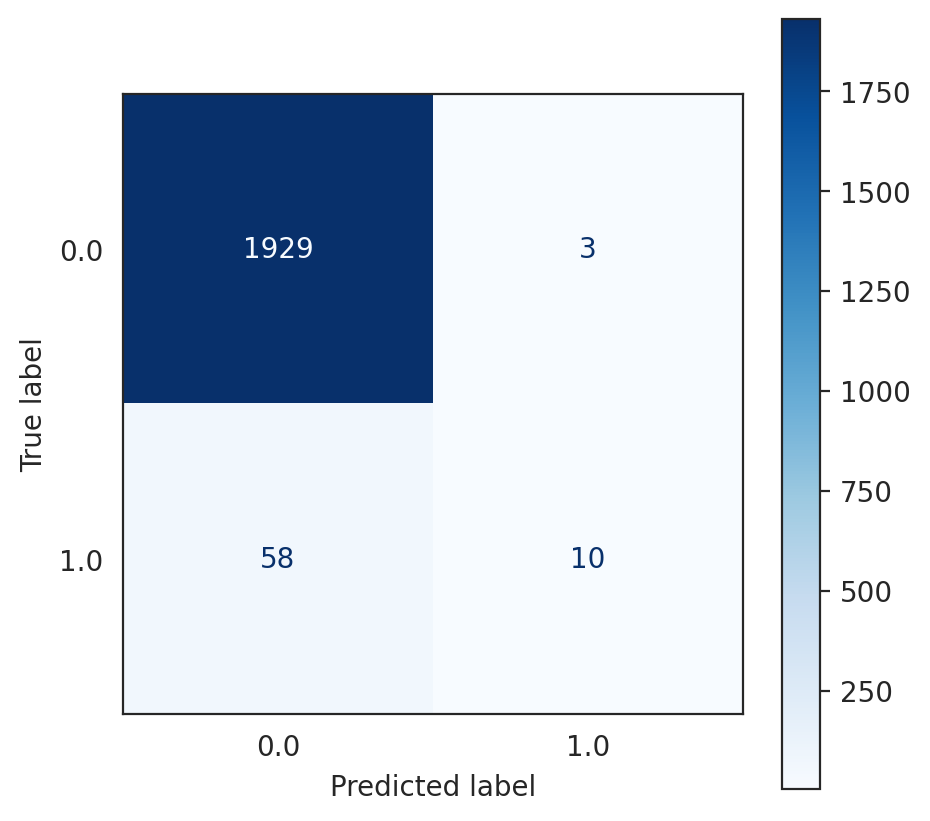

In [60]:
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    accuracy_score, recall_score, precision_score, f1_score,
    matthews_corrcoef, roc_auc_score, ConfusionMatrixDisplay
)

# Assuming X_train, X_test, y_train, y_test are already defined

start = time.time()
model = MLPClassifier(
    hidden_layer_sizes=(10,),  # Single hidden layer with 10 perceptrons
    activation='relu',  # Better for multi-perceptron networks
    solver='adam',  # Adaptive optimizer for better convergence
    max_iter=1000,  # Number of epochs
    verbose=True,  # Logs training progress
    random_state=0
).fit(X_train, y_train)

end_train = time.time()

# Predictions
y_predictions = model.predict(X_test)
end_predict = time.time()

# Metrics Calculation
accuracy = accuracy_score(y_test, y_predictions)
recall = recall_score(y_test, y_predictions, average='weighted')
precision = precision_score(y_test, y_predictions, average='weighted')
f1s = f1_score(y_test, y_predictions, average='weighted')
MCC = matthews_corrcoef(y_test, y_predictions)

# Handle potential error for ROC AUC
try:
    ROC_AUC = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1], average='weighted')
except AttributeError:
    print("Warning: predict_proba not available for ROC AUC calculation. Using default value.")
    ROC_AUC = 0

# Display Metrics
print("Accuracy:", "{:.2%}".format(accuracy))
print("Recall:", "{:.2%}".format(recall))
print("Precision:", "{:.2%}".format(precision))
print("F1-Score:", "{:.2%}".format(f1s))
print("MCC:", "{:.2%}".format(MCC))
print("ROC AUC score:", "{:.2%}".format(ROC_AUC))
print("Time to train:", "{:.2f}".format(end_train - start), "s")
print("Time to predict:", "{:.2f}".format(end_predict - end_train), "s")
print("Total time:", "{:.2f}".format(end_predict - start), "s")
print("Epochs Run:", model.n_iter_)  # Number of epochs actually completed

# Confusion Matrix Plot
plt.rcParams['figure.figsize'] = 5, 5
sns.set_style("white")
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap=plt.cm.Blues)
plt.show()


**Multilayer Multi Perceptron**

Iteration 1, loss = 0.57812006
Iteration 2, loss = 0.22511997
Iteration 3, loss = 0.15474384
Iteration 4, loss = 0.15009575
Iteration 5, loss = 0.14534877
Iteration 6, loss = 0.13983682
Iteration 7, loss = 0.13367143
Iteration 8, loss = 0.12683666
Iteration 9, loss = 0.11940277
Iteration 10, loss = 0.11140256
Iteration 11, loss = 0.10590052
Iteration 12, loss = 0.09935528
Iteration 13, loss = 0.09540340
Iteration 14, loss = 0.09241480
Iteration 15, loss = 0.09199148
Iteration 16, loss = 0.08935874
Iteration 17, loss = 0.08919629
Iteration 18, loss = 0.08757607
Iteration 19, loss = 0.08650773
Iteration 20, loss = 0.08723168
Iteration 21, loss = 0.08629435
Iteration 22, loss = 0.08526211
Iteration 23, loss = 0.08479757
Iteration 24, loss = 0.08397978
Iteration 25, loss = 0.08280371
Iteration 26, loss = 0.08193068
Iteration 27, loss = 0.08115112
Iteration 28, loss = 0.08030216
Iteration 29, loss = 0.08105617
Iteration 30, loss = 0.07897218
Iteration 31, loss = 0.07852029
Iteration 32, los

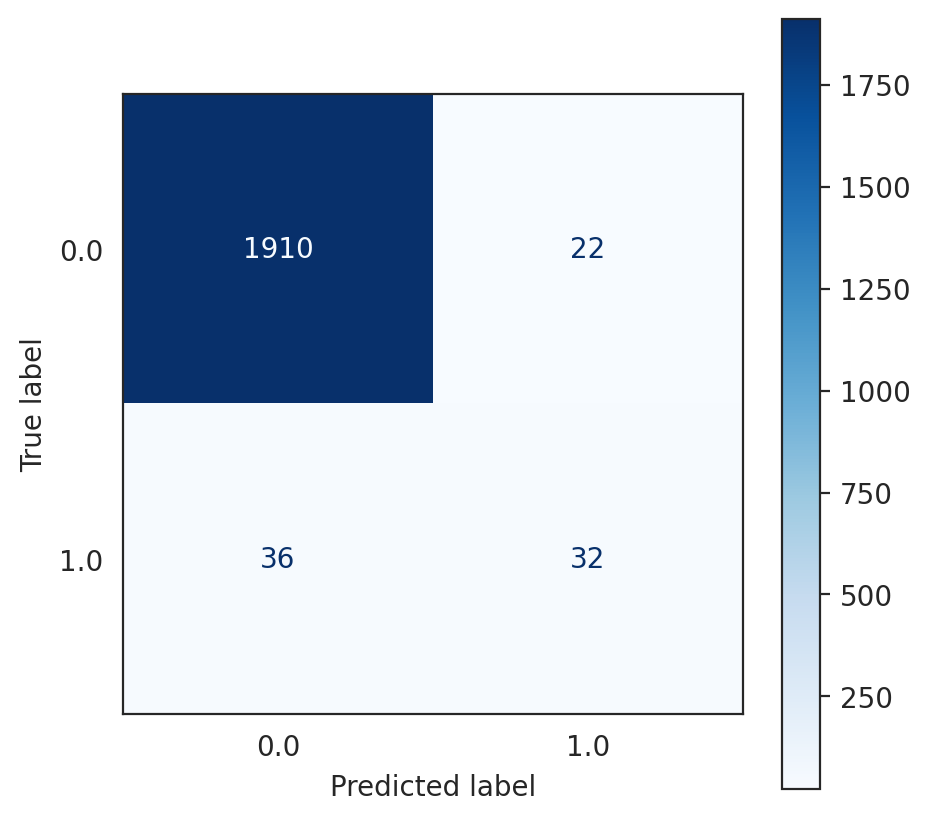

In [61]:
import time
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, matthews_corrcoef, roc_auc_score
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming X_train, X_test, y_train, y_test are already defined

start = time.time()
model = MLPClassifier(
    hidden_layer_sizes=(64, 32, 16),  # Three hidden layers (Multi-Layer)
    activation='relu',  # Best for multi-layer perceptrons
    solver='adam',  # Adaptive learning rate optimization
    max_iter=500,  # Number of epochs
    verbose=True,  # Show training progress
    random_state=0
).fit(X_train, y_train)
end_train = time.time()

y_predictions = model.predict(X_test)
end_predict = time.time()

# Evaluation Metrics
accuracy = accuracy_score(y_test, y_predictions)
recall = recall_score(y_test, y_predictions, average='weighted')
precision = precision_score(y_test, y_predictions, average='weighted')
f1s = f1_score(y_test, y_predictions, average='weighted')
MCC = matthews_corrcoef(y_test, y_predictions)

# Handle potential error for roc_auc_score if predict_proba isn't available
try:
    ROC_AUC = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1], average='weighted')
except AttributeError:
    print("Warning: predict_proba not available for ROC AUC calculation. Using default value.")
    ROC_AUC = 0  # Default value

# Print results
print("Accuracy:", "{:.2%}".format(accuracy))
print("Recall:", "{:.2%}".format(recall))
print("Precision:", "{:.2%}".format(precision))
print("F1-Score:", "{:.2%}".format(f1s))
print("MCC:", "{:.2%}".format(MCC))
print("ROC AUC score:", "{:.2%}".format(ROC_AUC))
print("Time to train:", "{:.2f}".format(end_train - start), "s")
print("Time to predict:", "{:.2f}".format(end_predict - end_train), "s")
print("Total time:", "{:.2f}".format(end_predict - start), "s")

# Plot Confusion Matrix
plt.rcParams['figure.figsize'] = (5, 5)
sns.set_style("white")
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap=plt.cm.Blues)
plt.show()


In [53]:
import plotly.graph_objects as go

# Assuming 'model_performance' DataFrame is already populated

fig = go.Figure()

# Add traces for each model
fig.add_trace(go.Bar(x=model_performance.index, y=model_performance['Accuracy'], name='Accuracy'))
fig.add_trace(go.Bar(x=model_performance.index, y=model_performance['Recall'], name='Recall'))
fig.add_trace(go.Bar(x=model_performance.index, y=model_performance['Precision'], name='Precision'))
fig.add_trace(go.Bar(x=model_performance.index, y=model_performance['F1-Score'], name='F1-Score'))
fig.add_trace(go.Bar(x=model_performance.index, y=model_performance['MCC score'], name='MCC Score'))
fig.add_trace(go.Bar(x=model_performance.index, y=model_performance['time to train'], name='Training Time'))
fig.add_trace(go.Bar(x=model_performance.index, y=model_performance['time to predict'], name='Prediction Time'))
fig.add_trace(go.Bar(x=model_performance.index, y=model_performance['total time'], name='Total Time'))


fig.update_layout(title='Model Performance Comparison',
                  xaxis_title='Model',
                  yaxis_title='Score',
                  barmode='group')  # Grouped bar chart

fig.show()


### 🔹 **Why ReLU for my Dataset?**  

My dataset involves **machine failure prediction**, which is a complex, **non-linear classification task** with continuous numerical features like temperature, torque, and rotational speed. Here's why **ReLU is a good choice for this data**:

#### ✅ **1. Handles Non-Linearity Well**  
- My dataset contains **complex, multi-dimensional relationships** between features (e.g., temperature, torque, rotational speed).  
- **ReLU introduces non-linearity**, allowing the model to **capture intricate failure patterns**, unlike sigmoid or tanh, which struggle with deep layers.  

#### ✅ **2. Efficient Training for Large-Scale Data**  
- My dataset has **10,000 rows and 14 features**, making it relatively large.  
- **ReLU does not saturate for positive values**, which helps in **faster and stable training** compared to sigmoid/tanh, which can lead to **vanishing gradients** in deep networks.  
- This allows efficient weight updates, making ReLU ideal for **both shallow and deep perceptrons** in my case.  

#### ✅ **3. Robust to Sensor Readings & Noise**  
- **My dataset has sensor-based features** like air temperature, process temperature, and rotational speed, which can have **fluctuations**.  
- **ReLU is robust** to slight variations in input values, unlike sigmoid/tanh, which are sensitive to small changes and may cause instability in training.  

#### ✅ **4. Works Well for Multi-Perceptron Models**  
- My **Multi-Layer Perceptron (MLP)** models benefit from ReLU because:  
  - It prevents neurons from becoming inactive (dying neurons are rare compared to sigmoid).  
  - It allows multiple layers to learn useful hierarchical features about machine failure.  
  - It speeds up training without complex calculations like exponentials in sigmoid/tanh.  

### 🔥 **Could Sigmoid/Tanh Work Instead?**  
❌ **Sigmoid:** Not ideal because it squashes large values to 0 or 1, making training slower (vanishing gradient issue).  
❌ **Tanh:** Better than sigmoid but still suffers from saturation for large values.  

### 🎯 **Conclusion:** **ReLU** is the best activation function for my dataset because it efficiently learns failure patterns, handles sensor data fluctuations, and allows deep networks to train effectively. 🚀

Pickling

In [62]:
import pickle


data_to_save = {
    'model': model,
    'X_test': X_test,
    'y_test': y_test,
    # ... add other variables you want to save
}


# Save the dictionary to a pickle file
with open('my_data.pkl', 'wb') as file:
    pickle.dump(data_to_save, file)
